In [ ]:
from google.colab import drive
drive.mount('/content/drive')

WAK_match = ['7cf8ef7e-d6af-4f49-b21d-a0f989f87021',
 'e596fe45-b5b3-47e4-877b-8c41cdcae3a4',
 '3212089f-4a7f-4657-ac3b-7c4a97a54b09']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
from datetime import datetime

import requests
import numpy as np
import time
import json
from collections import Counter
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

from PIL import Image
from scipy.stats import gaussian_kde
from scipy.spatial.distance import euclidean

import warnings

# FutureWarning 무시 설정
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [2]:
# 무기 장르 list
# hk416 = m4
AR = [
    'Item_Weapon_M16A4_C','Item_Weapon_HK416_C', 'Item_Weapon_AK47_C',
    'Item_Weapon_SCAR-L_C', 'Item_Weapon_G36C_C', 'Item_Weapon_BerylM762_C','Item_Weapon_QBZ95_C', 'Item_Weapon_Mk47Mutant_C',
    'Item_Weapon_AUG_C', 'Item_Weapon_Groza_C','Item_Weapon_ACE32_C','Item_Weapon_FAMASG2_C','Item_Weapon_K2_C']

DMR = [
    'Item_Weapon_Mini14_C', 'Item_Weapon_SKS_C', 'Item_Weapon_Mk14_C', 'Item_Weapon_Mk12_C', 'Item_Weapon_SLR_C',
    'Item_Weapon_QBU88_C', 'Item_Weapon_VSS_C', 'Item_Weapon_Dragunov_C','Item_Weapon_FNFal_C' ]


SMG = [
    'Item_Weapon_UZI_C', 'Item_Weapon_Vector_C', 'Item_Weapon_UMP_C', 'Item_Weapon_TommyGun_C', 'Item_Weapon_Thompson_C','Item_Weapon_Thompson_Old_C',
    'Item_Weapon_PP19Bizon_C','Item_Weapon_MP5K_C', 'Item_Weapon_P90_C','Item_Weapon_JS9_C','Item_Weapon_BizonPP19_C','Item_Weapon_vz61Skorpion_C']

SG = ['Item_Weapon_S686_C', 'Item_Weapon_S1897_C', 'Item_Weapon_S12K_C', 'Item_Weapon_DP12_C', 'Item_Weapon_SawedOff_C',
      'Item_Weapon_Saiga12_C','Item_Weapon_Berreta686_C']


SR = [
    'Item_Weapon_AWM_C', 'Item_Weapon_M24_C', 'Item_Weapon_Kar98k_C', 'Item_Weapon_Win94_C', 'Item_Weapon_MosinNagant_C'
    'Item_Weapon_LynxAMR_C','Item_Weapon_Winchester_C','Item_Weapon_Mosin_C']

Special = ['Item_Weapon_FlareGun_C','Item_Weapon_Mortar_C','Item_Weapon_PanzerFaust100M_C','Item_Weapon_Ziplinegun_C','Item_Weapon_Crossbow_C']

LMG = ['Item_Weapon_M249_C', 'Item_Weapon_DP28_C', 'Item_Weapon_MG3_C']

P = ['Item_Weapon_G18_C', 'Item_Weapon_M1911_C', 'Item_Weapon_M9_C', 'Item_Weapon_Rhino_C',
     'Item_Weapon_NagantM1895_C', 'Item_Weapon_Deagle_C']

Melee = ['Item_Weapon_Pan_C', 'Item_Weapon_Sickle_C', 'Item_Weapon_Machete_C', 'Item_Weapon_Crowbar_C']

Throwables = ['Item_Weapon_Grenade_C', 'Item_Weapon_Molotov_Cocktail_C', 'Item_Weapon_SmokeBomb_C',
              'Item_Weapon_StickyGrenade_C', 'Item_Weapon_StunGrenade_C']



# PUGB API KEY

In [ ]:
# PUBG API URL 및 API KEY 설정
# # 8NKW2-39FG4-9FJQF-HGRK4-X2D93
API_URL = "https://api.pubg.com"
API_KEY = '.FWqr78vTTarW0dc8Vqtk6oWzLAOOk8a6Otq0M-bvDDQ'


In [ ]:
# 요청 헤더 설정
headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Accept": "application/vnd.api+json"
}

# player id 별 matchid
def get_player_id(player_name):
    endpoint = f"/shards/steam/players?filter[playerNames]={player_name}"
    response = requests.get(API_URL + endpoint, headers=headers)
    if response.status_code == 200:
        data = response.json()
        if data:
            return data['data'][0]['relationships']['matches']['data']
        else:
            print(f"플레이어 {player_name}을 찾을 수 없습니다.")
            return None
    elif response.status_code == 429:
        print("API 요청이 너무 많습니다. 1분 동안 쉽니다.")
        time.sleep(60)  # 1분 동안 코드 실행을 지연시킵니다.
        return get_player_id(player_name)  # 재귀적으로 다시 시도합니다.
    else:
        print(f"Error: {response.status_code}")
        return None



# matchid 별 경기
def get_match_detail(match_id):
    url = 'https://api.pubg.com/shards/steam/matches/{}'
    url = url.format(match_id)
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        return None


# matchid 별로 경기 요약
# def get_match_details(match_ids):
#     all_match_details = []

#     for match_id in match_ids:
#         url = f'https://api.pubg.com/shards/steam/matches/{match_id}'
#         response = requests.get(url, headers=headers)

#         if response.status_code == 200:
#             all_match_details.append(response.json())

#         else:
#             print(f"Error: {response.status_code} for match ID {match_id}")

#     return all_match_details


#matchid 별로 경기 요약
def get_match_details(match_ids):
    all_match_details = []

    for i, match_id in enumerate(match_ids):
        url = f'https://api.pubg.com/shards/steam/matches/{match_id}'
        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            all_match_details.append(response.json())
        else:
            print(f"Error: {response.status_code} for match ID {match_id}")

        # 10개마다 1분 대기
        if (i + 1) % 10 == 0:
            print("Reached 10 requests, waiting for 1 minute...")
            time.sleep(61)

    return all_match_details



👉🏻 특정 기간동안의 매치데이터의 경우 sample 데이터만 수집이 가능하다..그런데 실제 유저의 데이터가 아니라 전부 ai 대결임

In [ ]:
def sample_player_data():
  # PUBG API endpoint and headers
  api_url = "https://api.pubg.com/shards/steam/matches"

  # Format the times in ISO 8601 format
  end_time_str = '2024-06-03T00:00:00Z' #end_time.strftime("%Y-%m-%dT%H:%M:%SZ")
  start_time_str = '2024-05-30T00:00:00Z' #start_time.strftime("%Y-%m-%dT%H:%M:%SZ")

  # Construct the URL with the query parameters
  params = {
      "filter[createdAt-start]": start_time_str,
      "filter[createdAt-end]": end_time_str
  }

  # Make the API request
  response = requests.get(api_url, headers=headers, params=params)
  data = response.json()
  return data


* 특정 유저별 최근 matchid 가져오기

In [ ]:
player_name = 'wakgood' # xiaosusu-9527 # 5b3f0f4b-7f8b-4d61-88a6-715a7186b7fa
data = get_player_id(player_name)
match_ids = [match['id'] for match in data]


In [ ]:
WAK_match = ['7cf8ef7e-d6af-4f49-b21d-a0f989f87021',
 'e596fe45-b5b3-47e4-877b-8c41cdcae3a4',
 '3212089f-4a7f-4657-ac3b-7c4a97a54b09']

ids = match_ids[4:]


* includid 매치별 참가자 기본통계
* 전투로그 같은 세부 정보는 asset key 를 이용해서 수집해야함

In [ ]:
match_datas = get_match_details(ids)

Reached 10 requests, waiting for 1 minute...
Reached 10 requests, waiting for 1 minute...
Reached 10 requests, waiting for 1 minute...
Reached 10 requests, waiting for 1 minute...
Reached 10 requests, waiting for 1 minute...
Reached 10 requests, waiting for 1 minute...


In [ ]:
len(match_datas)

68

### 매치 기본 통계와 Detail Log

In [ ]:
match_datas[0]['data']['id'] # matchid
# match_datas[0]['data']['attributes']['gameMode'] # game mode (Duo, Solo ...)
# match_datas[0]['data']['attributes']['mapName'] # 맵 이름

KeyError: 0

* 여러명의 player, matchids

In [ ]:
log_details = []
all_match_static = []
for i in range(len(ids)):
    match_data = match_datas[i]

    if match_data is None:
        continue  # match_datas[i]가 None인 경우 건너뜁니다.

    match_static = pd.json_normalize(match_data['included'], sep='_')
    all_match_static.append(match_static)

    # GameMode와 MapName 정보를 가져와서 DataFrame에 추가합니다.
    matchId = match_data['data']['id']
    game_mode = match_data['data']['attributes']['gameMode']
    map_name = match_data['data']['attributes']['mapName']
    timeSurvived = match_data['data']['attributes']['timeSurvived']

    # match_static DataFrame에 새로운 컬럼을 추가합니다.
    match_static['GameMode'] = game_mode
    match_static['MapName'] = map_name
    match_static['matchId'] = matchId


    # 각 asset의 URL과 관련 정보를 함께 저장합니다.
    asset_urls = match_static[match_static['type'] == 'asset']['attributes_URL'].tolist()
    for url in asset_urls:
        log_details.append({
            'url': url,
            'game_mode': game_mode,
            'map_name': map_name,
            'matchId': matchId,
            'timesurvied' : timeSurvived
        })



result = pd.concat(all_match_static, ignore_index=True)
result.columns = result.columns.str.replace('attributes_stats_', '')


In [ ]:
result.head()

type                                    id  DBNOs  assists  boosts  \
0  participant  05b20fb1-215f-41f6-9b1c-3820a2703e6e    0.0      0.0     0.0   
1  participant  0406dd0b-2fd9-402e-b3b4-f779d27d8913    2.0      1.0     5.0   
2  participant  a5d8df0b-4e1a-4902-9744-b961c4c635a8    0.0      0.0     0.0   
3  participant  705da0cd-4cdb-4c86-9640-9d9b771cb062    2.0      2.0     0.0   
4       roster  61cc179d-f7bf-4e87-91e7-d6e0e8c1a00b    NaN      NaN     NaN   

   damageDealt deathType  headshotKills  heals  killPlace  killStreaks  kills  \
0      0.00000  byplayer            0.0    0.0       81.0          0.0    0.0   
1    176.95999  byplayer            1.0    1.0       13.0          2.0    2.0   
2      0.00000  byplayer            0.0    0.0       95.0          0.0    0.0   
3    231.13997  byplayer            1.0    1.0       32.0          1.0    1.0   
4          NaN       NaN            NaN    NaN        NaN          NaN    NaN   

   longestKill           name                                  playerId  \
0     0.000000         Z512_-  account.11dc5b9e5d604b8989be2f147f2eea26   
1    16.892838   Redemption-F  account.6621a72e895947e684777cc2cee7c7b8   
2     0.000000      4bsolutes  account.53366be191f34045aff71277de6af5d3   
3    20.284431  oldman-romand  account.c7c63a53141740c0b47db1bb9e0f2839   
4          NaN            NaN                                       NaN   

   revives  rideDistance  roadKills  swimDistance  teamKills  timeSurvived  \
0      0.0        0.0000        0.0           0.0        0.0         109.0   
1      0.0     3223.3206        0.0           0.0        0.0         931.0   
2      0.0        0.0000        0.0           0.0        0.0          69.0   
3      2.0        0.0000        0.0           0.0        0.0         299.0   
4      NaN           NaN        NaN           NaN        NaN           NaN   

   vehicleDestroys  walkDistance  weaponsAcquired  winPlace attributes_actor  \
0              0.0     18.124760              1.0      19.0                    
1              0.0   1187.883400              7.0       4.0                    
2              0.0      3.828789              1.0      25.0                    
3              0.0    198.945500              2.0      14.0                    
4              NaN           NaN              NaN       NaN              NaN   

  attributes_shardId  rank  teamId attributes_won  relationships_team_data  \
0              steam   NaN     NaN            NaN                      NaN   
1              steam   NaN     NaN            NaN                      NaN   
2              steam   NaN     NaN            NaN                      NaN   
3              steam   NaN     NaN            NaN                      NaN   
4              steam  24.0    14.0          false                      NaN   

                     relationships_participants_data attributes_name  \
0                                                NaN             NaN   
1                                                NaN             NaN   
2                                                NaN             NaN   
3                                                NaN             NaN   
4  [{'type': 'participant', 'id': '77d9210f-30fb-...             NaN   

  attributes_description attributes_createdAt attributes_URL GameMode  \
0                    NaN                  NaN            NaN    squad   
1                    NaN                  NaN            NaN    squad   
2                    NaN                  NaN            NaN    squad   
3                    NaN                  NaN            NaN    squad   
4                    NaN                  NaN            NaN    squad   

       MapName                               matchId  
0  Savage_Main  86195e7d-a6c3-409d-bf7f-b8fb577708db  
1  Savage_Main  86195e7d-a6c3-409d-bf7f-b8fb577708db  
2  Savage_Main  86195e7d-a6c3-409d-bf7f-b8fb577708db  
3  Savage_Main  86195e7d-a6c3-409d-bf7f-b8fb577708db  
4  Savage_Main  86195e7d-

In [ ]:
result.columns

Index(['type', 'id', 'DBNOs', 'assists', 'boosts', 'damageDealt', 'deathType',
       'headshotKills', 'heals', 'killPlace', 'killStreaks', 'kills',
       'longestKill', 'name', 'playerId', 'revives', 'rideDistance',
       'roadKills', 'swimDistance', 'teamKills', 'timeSurvived',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPlace',
       'attributes_actor', 'attributes_shardId', 'rank', 'teamId',
       'attributes_won', 'relationships_team_data',
       'relationships_participants_data', 'attributes_name',
       'attributes_description', 'attributes_createdAt', 'attributes_URL',
       'GameMode', 'MapName', 'matchId'],
      dtype='object')

In [ ]:
# match_static = pd.json_normalize(match_datas['included'], sep='_')
match_df = result[(result['type']=='participant') & (result['name']== player_name)][['name','playerId','rank','kills', 'DBNOs', 'assists', 'boosts', 'damageDealt', 'deathType', 'headshotKills', 'killStreaks',
                                                                                     'revives','roadKills','timeSurvived','walkDistance','rideDistance','weaponsAcquired','GameMode','MapName',	'matchId']] #.sort_values(by=['attributes_stats_kills'])
match_df['timeSurvived'] = match_df['timeSurvived'] / 60

In [ ]:
match_10_list = match_df[match_df['timeSurvived'] >= 10]['matchId'].tolist()

In [ ]:
match_10_url = result[(result['matchId'].isin(match_10_list)) & ((result['attributes_URL'].notnull()))]['attributes_URL'].tolist()

In [ ]:
# match_datas 저장
csv_file_path = '/content/drive/MyDrive/dd.csv'
dd.to_csv(csv_file_path, index=False)

In [ ]:
player_names = result['name'].dropna().tolist()

In [ ]:
test_player = player_names[:20]

In [ ]:
# 플레이어 리스트에서 모든 match IDs를 가져오는 함수
def get_all_match_ids(player_names):
    all_match_ids = []
    for player_name in player_names:
        match_ids = get_player_id(player_name)
        if match_ids:
            all_match_ids.extend([match['id'] for match in match_ids])
    return all_match_ids

all_match_ids = get_all_match_ids(test_player)

len(all_match_ids)

API 요청이 너무 많습니다. 1분 동안 쉽니다.


1077

In [ ]:
#  중복없는 match_id 저장
match_ids = set(all_match_ids)
file_name = './test.txt'
with open(file_name, 'w+') as file:
    file.write('\n'.join(match_ids))

In [ ]:
# matchid 불러오기
file_name = '/content/test.txt'
# 파일을 읽어서 리스트로 저장
with open(file_name, 'r') as file:
    match_ids = file.read().splitlines()


In [ ]:
# match_datas 저장
csv_file_path = '/content/match_datas.csv'
result.to_csv(csv_file_path, index=False)


In [ ]:
len(result)

133681

* URL을 통해 불러오는 세부 데이터에는 MAP,DUO,MATCHID 정보가 없으므로 따로 추가해야하는 과정이 필요하다.

In [ ]:
log_details

In [ ]:
# log_details를 줄바꿈으로 구분하여 문자열로 변환
log_details_str = '\n'.join(map(str, log_details))

# 저장
file_name = 'log_details.txt'
with open(file_name, 'w') as file:
    file.write(log_details_str)


In [ ]:
# 게임타입 스쿼드가 제일 많음
solo_log = [log for log in log_details if log['game_mode'] == 'solo']
duo_log = [log for log in log_details if log['game_mode'] == 'duo']
squad_log = [log for log in log_details if log['game_mode'] == 'squad']

len(squad_log)

1

In [ ]:
log_details = [log for log in log_details if log['url'] in match_10_url]

In [ ]:
# 각 URL에 대해 요청을 보내고 응답 데이터를 DataFrame으로 변환하고 필요한 컬럼을 추가합니다.

def get_details(log_details):
  all_logs = []
  for i, detail in enumerate(log_details):
      url = detail['url']
      response = requests.get(url, headers=headers)
      if response.status_code == 200:
          logs = response.json()
          df = pd.json_normalize(logs)
          df['GameMode'] = detail['game_mode']
          df['MapName'] = detail['map_name']
          df['matchId'] = detail['matchId']
          all_logs.append(df)
      else:
          print(f"Failed to fetch data from {url}: {response.status_code}")

      # 10개마다 1분 대기
      if (i + 1) % 10 == 0:
          print("Reached 10 requests, waiting for 1 minute...")
          time.sleep(61)

  # 모든 로그 DataFrame을 결합합니다.
  all_logs_df = pd.concat(all_logs, ignore_index=True)

  return all_logs_df

wak_logs_df = get_details(log_details)



# url = 'https://telemetry-cdn.pubg.com/bluehole-pubg/steam/2024/06/22/12/56/c780bf29-3096-11ef-9c12-fabfacc66161-telemetry.json'
# response2 = requests.get(url, headers=headers)
# log = response2.json()

Reached 10 requests, waiting for 1 minute...
Reached 10 requests, waiting for 1 minute...
Reached 10 requests, waiting for 1 minute...


In [ ]:
# match_datas 저장
csv_file_path = '/content/drive/MyDrive/wak_logs_df.csv'
wak_logs_df.to_csv(csv_file_path, index=False)

# 주제 : 총기 밸런스

총기 밸런스 패치를 하기위해 어떤 정보를 봐야할까? 그리고 어떻게 전처리해야할까


라운드별 총기 인기도, 총기 상성(예를 들어 밴달 사용자와 팬텀 사용자의 맞대결에서 누가 우위에 있는지)


## 조건

* 다른 사람 개입 없이 1:1 싸움인 경우 (혹은 제3자 개입이 있는 경우 같이)
* 미러전은 따로 봐야함 (스카 vs 스카)
* 일방적인 공격이 아니어야함 (전면전 이어야함)
* 거리별로 다르게 봐야함
* 파츠별로 다르게 봐야함
* 도중 회복한 경우 어떻게 봐야할까..?

## 분석지표 정리

* 정확도, 탄퍼짐, 반동회복, 발사한 탄환수, 적중한 탄환

발로란트에서는 5초 이내에 발생한 멀티킬을 총기의 난사 제어를 알아보는데 지표로 사용

* 부위별 적중도
* 거리별 적중도 (5m 단위?)
* 총기 인기도
* 총기별 게임승률
* 1:1 전면전 승률
*

# 29.1 패치노트

SCAR-L과 AKM의 경우, 낮은 사용성과 승률로 인해 상향이 필요하다는 의견
* AKM : 피해량을 소폭 증가 (다른 AR에 비해 피해량이 강화)
* SCAR-L : 낮은 연사 속도를 소폭 증가 + 수직/수평 반동 각 4%씩 감소

* 판처파우스트에 장착 모션을 추가. 빠르게 줍거나 교체하여 발사할 수 없도록 조정

* Mk12의 경우 현재 가장 범용적으로 사용되는 DMR 총기 -> 사운드 인지 어려움(소음기+라이트그립 장착시 OP) -> 사운드만 조정


## 패치에 따른 사용성 분석
👉🏻 SCAR-L 과 AKM 의 사용성 체크 \

## 이외에 총기 분석 주제
> 근접전에서 가장 유리한 총은?
* 거리별 kill 지표




In [ ]:

# row 생략 없이 출력
pd.set_option('display.max_rows', None)
# col 생략 없이 출력
pd.set_option('display.max_columns', None)


cols= pd.DataFrame(df.columns)
cols

# item.itemId weapon.itemId weaponId isCustomGame gameState.numParticipatedPlayers distance damageCauserName damageReason



0
0                                            accountId
1                                                   _D
2                                                   _T
3                                        common.isGame
4                                       character.name
5                                     character.teamId
6                                     character.health
7                                 character.location.x
8                                 character.location.y
9                                 character.location.z
10                                   character.ranking
11                         character.individualRanking
12                                 character.accountId
13                              character.isInBlueZone
14                               character.isInRedZone
15                                      character.zone
16                                      character.type
17                                         item.itemId
18                                     item.stackCount
19                                       item.category
20                                    item.subCategory
21                                  item.attachedItems
22                                             vehicle
23                                         elapsedTime
24                                     numAlivePlayers
25                                            attackId
26                                fireWeaponStackCount
27                                          attackType
28                                       attacker.name
29                                     attacker.teamId
30                                     attacker.health
31                                 attacker.location.x
32                                 attacker.location.y
33                                 attacker.location.z
34                                    attacker.ranking
35                          attacker.individualRanking
36                                  attacker.accountId
37                               attacker.isInBlueZone
38                                attacker.isInRedZone
39                                       attacker.zone
40                                       attacker.type
41                                       weapon.itemId
42                                   weapon.stackCount
43                                     weapon.category
44                                  weapon.subCategory
45                                weapon.attachedItems
46                                         isLedgeGrab
47                                          objectType
48                                    objectTypeStatus
49                            objectTypeAdditionalInfo
50                                            weaponId
51                                           fireCount
52                                           seatIndex
53                                    fellowPassengers
54                                 vehicle.vehicleType
55                                   vehicle.vehicleId
56                                   vehicle.seatIndex
57                               vehicle.healthPercent
58                                 vehicle.feulPercent
59                                 vehicle.altitudeAbs
60                                 vehicle.altitudeRel
61                                    vehicle.velocity
62                               vehicle.isWheelsInAir
63                             vehicle.isInWaterVolume
64                                  vehicle.isEngineOn
65                                             mapName
66                                           weatherId
67                                          characters
68                                 cameraViewBehaviour
69                                            teamSize
70                                        isCustomGame
71                                         isEventMode
72                               blueZ

In [ ]:
df[['_T']].value_counts()

# LogPlayerPosition
# LogHeal

_T                          
LogPlayerPosition               5624
LogPlayerTakeDamage             4092
LogPlayerAttack                 3742
LogItemPickup                   3408
LogHeal                         2515
LogItemEquip                    1620
LogItemUnequip                  1405
LogItemAttach                    922
LogItemDetach                    909
LogItemUse                       896
LogItemDrop                      700
LogVaultStart                    629
LogObjectInteraction             620
LogItemPickupFromLootBox         344
LogPlayerUseThrowable            288
LogWeaponFireCount               282
LogVehicleRide                   149
LogVehicleLeave                  149
LogGameStatePeriodic             137
LogParachuteLanding              111
LogPlayerCreate                  101
LogPlayerLogin                    99
LogPlayerLogout                   99
LogPlayerKillV2                   94
LogPlayerMakeGroggy               59
LogVehicleDamage                  44
LogItemPi

In [ ]:
import re
kill_df = df[df['_T'].isin(['LogPlayerPosition','LogPlayerKillV2','LogPlayerAttack','LogPlayerTakeDamage','LogPlayerPosition','LogHeal'])] # 'LogPlayerKillV2','LogPlayerAttack',
# kill_df = kill_df.filter(regex=re.compile('_D|_T|attack|victim')) # |dBNO|wepon|finish
kill_df[(kill_df['attacker.name']== player_name)] #| (kill_df['victim.name'] == player_name)].sort_values(by=['_D']) #| (kill_df['dBNOMaker.name'] == player_name) | (kill_df['finisher.name'] == player_name)].sort_values(by=['_D'])


In [ ]:
kill_df[kill_df['_T'] == 'LogPlayerPosition'].sample(100)

MatchId PingQuality                        _D                 _T  \
28063     NaN         NaN  2024-05-24T14:23:17.658Z  LogPlayerPosition   
28577     NaN         NaN  2024-05-24T14:24:07.382Z  LogPlayerPosition   
30117     NaN         NaN  2024-05-24T14:26:02.445Z  LogPlayerPosition   
13161     NaN         NaN  2024-05-24T14:13:45.748Z  LogPlayerPosition   
5063      NaN         NaN  2024-05-24T14:11:23.073Z  LogPlayerPosition   
20333     NaN         NaN  2024-05-24T14:17:30.933Z  LogPlayerPosition   
15196     NaN         NaN  2024-05-24T14:14:31.643Z  LogPlayerPosition   
16836     NaN         NaN  2024-05-24T14:15:14.295Z  LogPlayerPosition   
25040     NaN         NaN  2024-05-24T14:20:50.487Z  LogPlayerPosition   
26688     NaN         NaN  2024-05-24T14:21:50.528Z  LogPlayerPosition   
6423      NaN         NaN  2024-05-24T14:11:39.295Z  LogPlayerPosition   
14352     NaN         NaN  2024-05-24T14:14:10.628Z  LogPlayerPosition   
21857     NaN         NaN  2024-05-24T14:18:50.179Z  LogPlayerPosition   
3858      NaN         NaN  2024-05-24T14:10:42.231Z  LogPlayerPosition   
3319      NaN         NaN  2024-05-24T14:09:55.741Z  LogPlayerPosition   
27716     NaN         NaN  2024-05-24T14:22:48.432Z  LogPlayerPosition   
4599      NaN         NaN  2024-05-24T14:11:13.087Z  LogPlayerPosition   
4489      NaN         NaN  2024-05-24T14:11:10.646Z  LogPlayerPosition   
4121      NaN         NaN  2024-05-24T14:10:59.170Z  LogPlayerPosition   
33761     NaN         NaN  2024-05-24T14:31:31.625Z  LogPlayerPosition   
32282     NaN         NaN  2024-05-24T14:28:54.647Z  LogPlayerPosition   
8859      NaN         NaN  2024-05-24T14:12:20.961Z  LogPlayerPosition   
9428      NaN         NaN  2024-05-24T14:12:30.616Z  LogPlayerPosition   
29630     NaN         NaN  2024-05-24T14:25:38.189Z  LogPlayerPosition   
22773     NaN         NaN  2024-05-24T14:19:24.644Z  LogPlayerPosition   
9572      NaN         NaN  2024-05-24T14:12:33.021Z  LogPlayerPosition   
4279      NaN         NaN  2024-05-24T14:11:04.405Z  LogPlayerPosition   
2288      NaN         NaN  2024-05-24T14:09:48.165Z  LogPlayerPosition   
24720     NaN         NaN  2024-05-24T14:20:38.588Z  LogPlayerPosition   
23890     NaN         NaN  2024-05-24T14:20:08.050Z  LogPlayerPosition   
29123     NaN         NaN  2024-05-24T14:25:01.610Z  LogPlayerPosition   
33067     NaN         NaN  2024-05-24T14:30:16.480Z  LogPlayerPosition   
9870      NaN         NaN  2024-05-24T14:12:38.049Z  LogPlayerPosition   
19869     NaN         NaN  2024-05-24T14:17:08.151Z  LogPlayerPosition   
4859      NaN         NaN  2024-05-24T14:11:19.272Z  LogPlayerPosition   
4328      NaN         NaN  2024-05-24T14:11:05.831Z  LogPlayerPosition   
8656      NaN         NaN  2024-05-24T14:12:17.607Z  LogPlayerPosition   
31844     NaN         NaN  2024-05-24T14:27:47.238Z  LogPlayerPosition   
34685     NaN         NaN  2024-05-24T14:32:48.168Z  LogPlayerPosition   
31618     NaN         NaN  2024-05-24T14:27:30.204Z  LogPlayerPosition   
909       NaN         NaN  2024-05-24T14:09:24.393Z  LogPlayerPosition   
13084     NaN         NaN  2024-05-24T14:13:44.767Z  LogPlayerPosition   
3930      NaN         NaN  2024-05-24T14:10:47.617Z  LogPlayerPosition   
6744      NaN         NaN  2024-05-24T14:11:44.775Z  LogPlayerPosition   
4303      NaN         NaN  2024-05-24T14:11:05.271Z  LogPlayerPosition   
25967     NaN         NaN  2024-05-24T14:21:21.634Z  LogPlayerPosition   
19499     NaN         NaN  2024-05-24T14:16:52.442Z  LogPlayerPosition   
13658     NaN         NaN  2024-05-24T14:13:55.429Z  LogPlayerPosition   
28281     NaN         NaN  2024-05-24T14:23:37.233Z  LogPlayerPosition   
24589     NaN         NaN  2024-05-24T14:20:33.076Z  LogPlayerPosition   
932       NaN         NaN  2024-05-24T14:09:24.966Z  LogPlayerPosition   
29947     NaN         NaN  2024-05-24T14:25:52.458Z  LogPlayerPosition   
10327     NaN         NaN  2024-05-24T14:12:47.708Z  LogPlayerPosition   
4297      

In [ ]:
# 힐을 사용한 유저의 컬럼은 character.name 에서 남음.
heal_df = df[df['_T'].isin(['LogPlayerTakeDamage'])]
heal_df.head(100)

MatchId PingQuality                        _D                   _T  \
4071     NaN         NaN  2024-05-24T14:10:56.564Z  LogPlayerTakeDamage   
4110     NaN         NaN  2024-05-24T14:10:58.582Z  LogPlayerTakeDamage   
4150     NaN         NaN  2024-05-24T14:10:59.874Z  LogPlayerTakeDamage   
4152     NaN         NaN  2024-05-24T14:10:59.909Z  LogPlayerTakeDamage   
4180     NaN         NaN  2024-05-24T14:11:00.701Z  LogPlayerTakeDamage   
4184     NaN         NaN  2024-05-24T14:11:00.782Z  LogPlayerTakeDamage   
4192     NaN         NaN  2024-05-24T14:11:00.883Z  LogPlayerTakeDamage   
4203     NaN         NaN  2024-05-24T14:11:01.122Z  LogPlayerTakeDamage   
4224     NaN         NaN  2024-05-24T14:11:02.264Z  LogPlayerTakeDamage   
4239     NaN         NaN  2024-05-24T14:11:02.615Z  LogPlayerTakeDamage   
4243     NaN         NaN  2024-05-24T14:11:02.797Z  LogPlayerTakeDamage   
4261     NaN         NaN  2024-05-24T14:11:03.810Z  LogPlayerTakeDamage   
4277     NaN         NaN  2024-05-24T14:11:04.296Z  LogPlayerTakeDamage   
4292     NaN         NaN  2024-05-24T14:11:04.805Z  LogPlayerTakeDamage   
4305     NaN         NaN  2024-05-24T14:11:05.304Z  LogPlayerTakeDamage   
4327     NaN         NaN  2024-05-24T14:11:05.830Z  LogPlayerTakeDamage   
4339     NaN         NaN  2024-05-24T14:11:06.301Z  LogPlayerTakeDamage   
4351     NaN         NaN  2024-05-24T14:11:06.807Z  LogPlayerTakeDamage   
4364     NaN         NaN  2024-05-24T14:11:07.309Z  LogPlayerTakeDamage   
4387     NaN         NaN  2024-05-24T14:11:07.814Z  LogPlayerTakeDamage   
4400     NaN         NaN  2024-05-24T14:11:08.289Z  LogPlayerTakeDamage   
4424     NaN         NaN  2024-05-24T14:11:08.837Z  LogPlayerTakeDamage   
4437     NaN         NaN  2024-05-24T14:11:09.297Z  LogPlayerTakeDamage   
4449     NaN         NaN  2024-05-24T14:11:09.796Z  LogPlayerTakeDamage   
4476     NaN         NaN  2024-05-24T14:11:10.309Z  LogPlayerTakeDamage   
4500     NaN         NaN  2024-05-24T14:11:10.794Z  LogPlayerTakeDamage   
4522     NaN         NaN  2024-05-24T14:11:11.311Z  LogPlayerTakeDamage   
4538     NaN         NaN  2024-05-24T14:11:11.824Z  LogPlayerTakeDamage   
4557     NaN         NaN  2024-05-24T14:11:12.281Z  LogPlayerTakeDamage   
4583     NaN         NaN  2024-05-24T14:11:12.826Z  LogPlayerTakeDamage   
4615     NaN         NaN  2024-05-24T14:11:13.315Z  LogPlayerTakeDamage   
4642     NaN         NaN  2024-05-24T14:11:13.809Z  LogPlayerTakeDamage   
4666     NaN         NaN  2024-05-24T14:11:14.308Z  LogPlayerTakeDamage   
4700     NaN         NaN  2024-05-24T14:11:14.811Z  LogPlayerTakeDamage   
4715     NaN         NaN  2024-05-24T14:11:15.288Z  LogPlayerTakeDamage   
4731     NaN         NaN  2024-05-24T14:11:15.801Z  LogPlayerTakeDamage   
4747     NaN         NaN  2024-05-24T14:11:16.304Z  LogPlayerTakeDamage   
4762     NaN         NaN  2024-05-24T14:11:16.828Z  LogPlayerTakeDamage   
4782     NaN         NaN  2024-05-24T14:11:17.290Z  LogPlayerTakeDamage   
4802     NaN         NaN  2024-05-24T14:11:17.797Z  LogPlayerTakeDamage   
4822     NaN         NaN  2024-05-24T14:11:18.283Z  LogPlayerTakeDamage   
4846     NaN         NaN  2024-05-24T14:11:18.814Z  LogPlayerTakeDamage   
4860     NaN         NaN  2024-05-24T14:11:19.307Z  LogPlayerTakeDamage   
4882     NaN         NaN  2024-05-24T14:11:19.813Z  LogPlayerTakeDamage   
4905     NaN         NaN  2024-05-24T14:11:20.279Z  LogPlayerTakeDamage   
4907     NaN         NaN  2024-05-24T14:11:20.294Z  LogPlayerTakeDamage   
4940     NaN         NaN  2024-05-24T14:11:20.827Z  LogPlayerTakeDamage   
4964     NaN         NaN  2024-05-24T14:11:21.285Z  LogPlayerTakeDamage   
4992     NaN         NaN  2024-05-24T14:11:21.796Z  LogPlayerTakeDamage   
5024     NaN         NaN  2024-05-24T14:11:22.292Z  LogPlayerTakeDamage   
5048     NaN         NaN  2024-05-24T14:11:22.851Z  LogPlayerTakeDamage   
5066     NaN         NaN  2024-05-24T14:11:23.159Z  LogPlayerTakeDamage   
5080     NaN         NaN  2024

## 지표와 관련하여 규칙 정리

* LogPlayerTakeDamage 에서 attacker.name	가 없는 경우 자기장에 맞은 것
* position 은 10초 단위로 남겨지고 있음
* 사람간의 전투만 필요하므로 _T 가 LogPlayerTakeDamage 이고 attacker.name 이 nan 인경우 제거해야함
* 확정 KILL을 한 경우, 거리에 관한 지표가 나온다.
* 하지만 공격 당시의 세세한 로그는, Attack한 사람과 Damage를 받은 사람간의 좌표의 차이를 통해서 거리를 구해야한다.

* fireWeaponStackCount 은 총기별로 누적 카운트 된다.
* 총기별로 몇발을 쏘고(`fireWeaponStackCount`), 얼만큼 맞췄는지 (`LogTakeDamage`) 구할 수 있다.  

LogMatchEnd 경기가 끝났을 때, 아래의 로그가 남는다.
* allWeaponStats	gameResultOnFinished.results	GameMode	MapName	matchId


In [ ]:
# 확정킬 log
# LogPlayerKill_df = df[df['_T'] == 'LogPlayerKillV2']

LogPlayerKill_df = df[df['_T'].isin(['LogPlayerPosition','LogPlayerKillV2','LogPlayerAttack','LogPlayerTakeDamage','LogHeal'])] # 'LogPlayerKillV2','LogPlayerAttack',


kill_sample = LogPlayerKill_df[['_D','_T',
                  'character.name','character.health','healAmount','' # healLog와 관련된 컬럼
                  'attacker.name','attackType','attacker.health','attacker.location.x', 'attacker.location.y','attacker.location.z','damageTypeCategory','damage','weapon.itemId','weapon.stackCount','fireWeaponStackCount', # 공격 하나하나 관련된 로그 (당시 공격한 위치는 나오지 않음, 맞은 경우 나옴)
                  'victim.name','damageReason','victimWeapon','victim.health','victim.location.x', 'victim.location.y','victim.location.z','victimWeaponAdditionalInfo','assists_AccountId','victimGameResult.stats.statTrakDataPairs','victimGameResult.stats.headshotStatTrakDataPairs' ,# 피해를 받은 유저
                  'dBNOMaker.name','dBNODamageInfo.damageReason','dBNODamageInfo.damageTypeCategory','dBNODamageInfo.damageCauserName','dBNODamageInfo.additionalInfo','dBNODamageInfo.distance', # 기절을 만든 유저
                  'finisher.name','finisher.health','finishDamageInfo.damageReason','finishDamageInfo.damageTypeCategory','finishDamageInfo.damageCauserName','finishDamageInfo.additionalInfo','finishDamageInfo.distance', # 마무리 유저?
                  'killer.name','killer.health','killerDamageInfo.damageReason','killerDamageInfo.damageTypeCategory','killerDamageInfo.damageCauserName','killerDamageInfo.additionalInfo','killerDamageInfo.distance']] # 킬러 유저?


* ONLY 총으로 인해 받은 damage_log

In [ ]:
from scipy.spatial.distance import euclidean
kill_sample_damage = kill_sample[(kill_sample['_T'].isin(['LogPlayerTakeDamage','LogPlayerAttack'])) & (kill_sample['damageTypeCategory'] == 'Damage_Gun')]

# 각 좌표의 값을 가져오기
attacker_x = kill_sample_damage['attacker.location.x']
attacker_y = kill_sample_damage['attacker.location.y']
attacker_z = kill_sample_damage['attacker.location.z']

victim_x = kill_sample_damage['victim.location.x']
victim_y = kill_sample_damage['victim.location.y']
victim_z = kill_sample_damage['victim.location.z']

# 거리 계산하여 'distance' 열에 추가
kill_sample_damage['distance'] = kill_sample_damage.apply(lambda row: euclidean((row['attacker.location.x'], row['attacker.location.y'], row['attacker.location.z']),
                                                (row['victim.location.x'], row['victim.location.y'], row['victim.location.z'])), axis=1)



kill_sample_damage

<ipython-input-92-c4e851df97c2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kill_sample_damage['distance'] = kill_sample_damage.apply(lambda row: euclidean((row['attacker.location.x'], row['attacker.location.y'], row['attacker.location.z']),


_D                   _T character.name  \
4110   2024-05-24T14:10:58.582Z  LogPlayerTakeDamage            NaN   
4150   2024-05-24T14:10:59.874Z  LogPlayerTakeDamage            NaN   
4152   2024-05-24T14:10:59.909Z  LogPlayerTakeDamage            NaN   
4180   2024-05-24T14:11:00.701Z  LogPlayerTakeDamage            NaN   
4184   2024-05-24T14:11:00.782Z  LogPlayerTakeDamage            NaN   
4192   2024-05-24T14:11:00.883Z  LogPlayerTakeDamage            NaN   
4203   2024-05-24T14:11:01.122Z  LogPlayerTakeDamage            NaN   
4224   2024-05-24T14:11:02.264Z  LogPlayerTakeDamage            NaN   
4239   2024-05-24T14:11:02.615Z  LogPlayerTakeDamage            NaN   
4905   2024-05-24T14:11:20.279Z  LogPlayerTakeDamage            NaN   
5218   2024-05-24T14:11:24.746Z  LogPlayerTakeDamage            NaN   
5222   2024-05-24T14:11:24.749Z  LogPlayerTakeDamage            NaN   
5223   2024-05-24T14:11:24.796Z  LogPlayerTakeDamage            NaN   
5241   2024-05-24T14:11:24.903Z  LogPlayerTakeDamage            NaN   
5252   2024-05-24T14:11:24.957Z  LogPlayerTakeDamage            NaN   
5262   2024-05-24T14:11:25.061Z  LogPlayerTakeDamage            NaN   
5266   2024-05-24T14:11:25.067Z  LogPlayerTakeDamage            NaN   
5280   2024-05-24T14:11:25.122Z  LogPlayerTakeDamage            NaN   
5294   2024-05-24T14:11:25.230Z  LogPlayerTakeDamage            NaN   
5296   2024-05-24T14:11:25.235Z  LogPlayerTakeDamage            NaN   
5306   2024-05-24T14:11:25.299Z  LogPlayerTakeDamage            NaN   
5324   2024-05-24T14:11:25.462Z  LogPlayerTakeDamage            NaN   
5332   2024-05-24T14:11:25.471Z  LogPlayerTakeDamage            NaN   
5334   2024-05-24T14:11:25.516Z  LogPlayerTakeDamage            NaN   
5338   2024-05-24T14:11:25.572Z  LogPlayerTakeDamage            NaN   
5356   2024-05-24T14:11:25.687Z  LogPlayerTakeDamage            NaN   
5363   2024-05-24T14:11:25.752Z  LogPlayerTakeDamage            NaN   
5378   2024-05-24T14:11:25.817Z  LogPlayerTakeDamage            NaN   
5383   2024-05-24T14:11:25.920Z  LogPlayerTakeDamage            NaN   
5387   2024-05-24T14:11:26.011Z  LogPlayerTakeDamage            NaN   
5479   2024-05-24T14:11:27.891Z  LogPlayerTakeDamage            NaN   
5488   2024-05-24T14:11:28.046Z  LogPlayerTakeDamage            NaN   
5500   2024-05-24T14:11:28.174Z  LogPlayerTakeDamage            NaN   
5518   2024-05-24T14:11:28.405Z  LogPlayerTakeDamage            NaN   
5574   2024-05-24T14:11:29.058Z  LogPlayerTakeDamage            NaN   
5577   2024-05-24T14:11:29.066Z  LogPlayerTakeDamage            NaN   
5616   2024-05-24T14:11:29.532Z  LogPlayerTakeDamage            NaN   
5651   2024-05-24T14:11:30.001Z  LogPlayerTakeDamage            NaN   
5663   2024-05-24T14:11:30.169Z  LogPlayerTakeDamage            NaN   
5721   2024-05-24T14:11:30.963Z  LogPlayerTakeDamage            NaN   
5735   2024-05-24T14:11:31.142Z  LogPlayerTakeDamage            NaN   
5757   2024-05-24T14:11:31.411Z  LogPlayerTakeDamage            NaN   
5775   2024-05-24T14:11:31.556Z  LogPlayerTakeDamage            NaN   
5778   2024-05-24T14:11:31.603Z  LogPlayerTakeDamage            NaN   
5845   2024-05-24T14:11:32.396Z  LogPlayerTakeDamage            NaN   
5886   2024-05-24T14:11:32.994Z  LogPlayerTakeDamage            NaN   
5939   2024-05-24T14:11:33.564Z  LogPlayerTakeDamage            NaN   
5949   2024-05-24T14:11:33.710Z  LogPlayerTakeDamage            NaN   
5964   2024-05-24T14:11:33.853Z  LogPlayerTakeDamage            NaN   
6003   2024-05-24T14:11:34.332Z  LogPlayerTakeDamage            NaN   
6022   2024-05-24T14:11:34.556Z  LogPlayerTakeDamage            NaN   
6027   2024-05-24T14:11:34.598Z  LogPlayerTakeDamage            NaN   
6046   2024-05-24T14:11:34.836Z  LogPlayerTakeDamage            NaN   
6112   2024-05-24T14:11:35.659Z  LogPlayerTakeDamage            NaN   
6134   2024-05-24T14:11:35.849Z  LogPlayerTakeDamage            NaN   
6170   2024-05-24T14:11:36.361Z  LogPlayerTakeDamage 

In [ ]:
# 'attacker.name', 'victim.name', 'killer.name', 'finisher.name' 컬럼 중 값이 player_name인 경우만 가져오기
cols = (kill_sample['attacker.name'] == player_name) | (kill_sample['victim.name'] == player_name) | (kill_sample['killer.name'] == player_name) | (kill_sample['finisher.name'] == player_name) | (kill_sample['character.name'] == player_name)
player_values = kill_sample[cols]
player_values

_D                   _T    character.name  \
70     2024-05-24T14:08:40.493Z    LogPlayerPosition  VINGMINGVINGMING   
214    2024-05-24T14:08:50.457Z    LogPlayerPosition  VINGMINGVINGMING   
361    2024-05-24T14:09:00.479Z    LogPlayerPosition  VINGMINGVINGMING   
525    2024-05-24T14:09:10.471Z    LogPlayerPosition  VINGMINGVINGMING   
765    2024-05-24T14:09:20.467Z    LogPlayerPosition  VINGMINGVINGMING   
1108   2024-05-24T14:09:30.463Z    LogPlayerPosition  VINGMINGVINGMING   
1830   2024-05-24T14:09:40.494Z    LogPlayerPosition  VINGMINGVINGMING   
2491   2024-05-24T14:09:50.484Z    LogPlayerPosition  VINGMINGVINGMING   
3363   2024-05-24T14:10:00.494Z    LogPlayerPosition  VINGMINGVINGMING   
3464   2024-05-24T14:10:10.485Z    LogPlayerPosition  VINGMINGVINGMING   
3582   2024-05-24T14:10:20.497Z    LogPlayerPosition  VINGMINGVINGMING   
3713   2024-05-24T14:10:30.483Z    LogPlayerPosition  VINGMINGVINGMING   
3835   2024-05-24T14:10:40.477Z    LogPlayerPosition  VINGMINGVINGMING   
3968   2024-05-24T14:10:50.486Z    LogPlayerPosition  VINGMINGVINGMING   
4171   2024-05-24T14:11:00.490Z    LogPlayerPosition  VINGMINGVINGMING   
4483   2024-05-24T14:11:10.492Z    LogPlayerPosition  VINGMINGVINGMING   
4916   2024-05-24T14:11:20.491Z    LogPlayerPosition  VINGMINGVINGMING   
5683   2024-05-24T14:11:30.516Z    LogPlayerPosition  VINGMINGVINGMING   
6485   2024-05-24T14:11:40.484Z    LogPlayerPosition  VINGMINGVINGMING   
7129   2024-05-24T14:11:50.511Z    LogPlayerPosition  VINGMINGVINGMING   
7674   2024-05-24T14:12:00.483Z    LogPlayerPosition  VINGMINGVINGMING   
8227   2024-05-24T14:12:10.507Z    LogPlayerPosition  VINGMINGVINGMING   
8827   2024-05-24T14:12:20.481Z    LogPlayerPosition  VINGMINGVINGMING   
9420   2024-05-24T14:12:30.475Z    LogPlayerPosition  VINGMINGVINGMING   
9977   2024-05-24T14:12:40.483Z    LogPlayerPosition  VINGMINGVINGMING   
10435  2024-05-24T14:12:50.499Z    LogPlayerPosition  VINGMINGVINGMING   
10918  2024-05-24T14:13:00.504Z    LogPlayerPosition  VINGMINGVINGMING   
11385  2024-05-24T14:13:10.486Z    LogPlayerPosition  VINGMINGVINGMING   
11847  2024-05-24T14:13:20.501Z    LogPlayerPosition  VINGMINGVINGMING   
12332  2024-05-24T14:13:30.502Z    LogPlayerPosition  VINGMINGVINGMING   
12848  2024-05-24T14:13:40.475Z    LogPlayerPosition  VINGMINGVINGMING   
13386  2024-05-24T14:13:50.505Z    LogPlayerPosition  VINGMINGVINGMING   
13960  2024-05-24T14:14:00.483Z    LogPlayerPosition  VINGMINGVINGMING   
14343  2024-05-24T14:14:10.494Z    LogPlayerPosition  VINGMINGVINGMING   
14771  2024-05-24T14:14:20.488Z    LogPlayerPosition  VINGMINGVINGMING   
15132  2024-05-24T14:14:30.480Z    LogPlayerPosition  VINGMINGVINGMING   
15566  2024-05-24T14:14:40.484Z    LogPlayerPosition  VINGMINGVINGMING   
15909  2024-05-24T14:14:50.503Z    LogPlayerPosition  VINGMINGVINGMING   
16313  2024-05-24T14:15:00.490Z    LogPlayerPosition  VINGMINGVINGMING   
16680  2024-05-24T14:15:10.479Z    LogPlayerPosition  VINGMINGVINGMING   
17049  2024-05-24T14:15:20.471Z    LogPlayerPosition  VINGMINGVINGMING   
17305  2024-05-24T14:15:30.498Z    LogPlayerPosition  VINGMINGVINGMING   
17653  2024-05-24T14:15:40.502Z    LogPlayerPosition  VINGMINGVINGMING   
17967  2024-05-24T14:15:50.499Z    LogPlayerPosition  VINGMINGVINGMING   
18309  2024-05-24T14:16:00.486Z    LogPlayerPosition  VINGMINGVINGMING   
18583  2024-05-24T14:16:10.476Z    LogPlayerPosition  VINGMINGVINGMING   
18833  2024-05-24T14:16:20.501Z    LogPlayerPosition  VINGMINGVINGMING   
19042  2024-05-24T14:16:30.497Z    LogPlayerPosition  VINGMINGVINGMING   
19262  2024-05-24T14:16:40.485Z    LogPlayerPosition  VINGMINGVINGMING   
19468  2024-05-24T14:16:50.472Z    LogPlayerPosition  VINGMINGVINGMING   
19644  2024-05-24T14:17:00.492Z    LogPlayerPosition  VINGMINGVINGMING   
19728  2024-05-24T14:17:04.158Z      LogPlayerAttack               NaN   
19729  2024-05-24T14:17:04.159Z  LogPlayerTakeDamage               NaN   
19744  2024-05-24T14:17:04.826Z  

* KILL을 확정 낸 경우에만  statTrakDataPairs 로그들이 남는다. 그런데 총관련 밖에 없음.. VALUE 값이 아이템 값인지, 헤드샷 횟수인지 모르겟네

* damageReason 의 경우 피해를 받은 입장에서 로그가 남는다.

In [ ]:
test = kill[['_D','_T','victimGameResult.stats.statTrakDataPairs','victimGameResult.stats.headshotStatTrakDataPairs']]

In [ ]:
from pandas import json_normalize

normalized_data = pd.concat([json_normalize(x) for x in test['victimGameResult.stats.statTrakDataPairs']], ignore_index=True)

In [ ]:
normalized_data

gameItemId  \
0            Item_Skin_SKS_Apocalypse_01_C   
1                 Item_Skin_M762_Dino_01_C   
2                Item_Skin_K2_Unicorn_01_C   
3              Item_Skin_FNFAL_23XMAS_01_C   
4             Item_Skin_Mini14_Pirate_01_C   
5        Item_Skin_M24_Wukong_LV1_01_lv3_C   
6             Item_Skin_HK416_23Bunny_01_C   
7        Item_Skin_FNFAL_Goth_LV2_01_lv9_C   
8  Item_Skin_M762_BlueDragon_LV3_01_lv10_C   

   value  
0     20  
1    116  
2      4  
3      4  
4      6  
5     33  
6     15  
7    227  
8    334


결론, 총기별로 어떤 위치를 얼만큼 맞췄는지 보기 위해서 필요한 컬럼은

TYPE = LogPlayerAttack

* attacker.name
* attackType
* damageReason
* attacker.health
* victim.name


In [ ]:
test = player_values[player_values['_T'].isin(['LogPlayerAttack','LogPlayerTakeDamage'])]
test[['attacker.name','attackType','damageReason','attacker.health','victim.name','victim.health']]

NameError: name 'player_values' is not defined

# 첫번째 지표 - 사용성

## 인기도
* TOP30가 장착한 총기비율을 구해주세요
* 어떤 총기가 가장 많이 쓰였는지 확인해주세요
* 유저는 어떤 총을 보면 갈아끼울까요?

In [ ]:
# solo log
df = pd.read_csv("/content/drive/MyDrive/PUBG/solo_log_data.csv", encoding = "UTF-8")

<ipython-input-3-8acb7316a459>:2: DtypeWarning: Columns (0,4,43,45,46,48,49,50,51,52,55,56,57,64,65,66,67,68,69,70,72,73,74,102,104,105,106,107,109,110,111,112,113,115,116,117,125,126,127,128,129,131,132,134,135,136,153,154,155,156,157,158,159,160,162,163,171,172,173,174,175,176,177,178,179,181,182,190,191,192,193,194,195,196,197,198,200,203,208,211,215,217,222,223,224,232,233,234,235,236,237,238,242,243,244,252,253,254,255,256,257,265,266,267,268,269) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/PUBG/solo_log_data.csv", encoding = "UTF-8")


In [ ]:
# 전체 match_id
file_path = '/content/drive/MyDrive/PUBG/log_details.txt'
f = open(file_path,"r")
data = f.read().split("\n")

# 각 요소를 파싱하여 JSON 객체로 변환하고 큰따옴표를 제거
log_details = []
for item in data:
    item_dict = json.loads(item.replace("'", '"'))
    log_details.append(item_dict)

In [ ]:
# 게임타입 스쿼드가 제일 많음
solo_log = [log for log in log_details if log['game_mode'] == 'solo']
duo_log = [log for log in log_details if log['game_mode'] == 'duo' and '2024/06' in log['url']] #6월 데이터만
squad_log = [log for log in log_details if log['game_mode'] == 'squad' and '2024/06' in log['url']]

map_name = [item['map_name'] for item in duo_log]
Counter(map_name)

Counter({'Savage_Main': 39,
         'DihorOtok_Main': 20,
         'Baltic_Main': 6,
         'Tiger_Main': 3})

In [ ]:
import random
sample_duo = random.sample(duo_log, 30)
sample_squad = random.sample(squad_log, 30)

In [ ]:
# duo 데이터
duo_sample = get_details(sample_duo)

# match_datas 저장
csv_file_path = '/content/drive/MyDrive/duo_log_data.csv'
duo_sample.to_csv(csv_file_path, index=False)

Reached 10 requests, waiting for 1 minute...
Reached 10 requests, waiting for 1 minute...
Reached 10 requests, waiting for 1 minute...


In [ ]:
# Savage_Main     29 사녹
# Chimera_Main     7 사녹 파라모
# Erangel_Main     4 에란겔
# Neon_Main        3 헤이
# Tiger_Main       2 에란겔 태이고

df[['mapName']].value_counts()

mapName     
Savage_Main     29
Chimera_Main     7
Erangel_Main     4
Neon_Main        3
Tiger_Main       2
Name: count, dtype: int64

In [ ]:
# 유저는 어떤 총을 보면 갈아끼울까?
cols = pd.DataFrame(player_df.columns)
cols


0
0                                              MatchId
1                                          PingQuality
2                                                   _D
3                                                   _T
4                                            accountId
5                                        common.isGame
6                                       character.name
7                                     character.teamId
8                                     character.health
9                                 character.location.x
10                                character.location.y
11                                character.location.z
12                                   character.ranking
13                         character.individualRanking
14                                 character.accountId
15                              character.isInBlueZone
16                               character.isInRedZone
17                                      character.zone
18                                      character.type
19                                         item.itemId
20                                     item.stackCount
21                                       item.category
22                                    item.subCategory
23                                  item.attachedItems
24                                             vehicle
25                                         elapsedTime
26                                     numAlivePlayers
27                                            attackId
28                                fireWeaponStackCount
29                                          attackType
30                                       attacker.name
31                                     attacker.teamId
32                                     attacker.health
33                                 attacker.location.x
34                                 attacker.location.y
35                                 attacker.location.z
36                                    attacker.ranking
37                          attacker.individualRanking
38                                  attacker.accountId
39                               attacker.isInBlueZone
40                                attacker.isInRedZone
41                                       attacker.zone
42                                       attacker.type
43                                       weapon.itemId
44                                   weapon.stackCount
45                                     weapon.category
46                                  weapon.subCategory
47                                weapon.attachedItems
48                                          objectType
49                                    objectTypeStatus
50                            objectTypeAdditionalInfo
51                                         isLedgeGrab
52                                            weaponId
53                                           fireCount
54                                           seatIndex
55                                    fellowPassengers
56                                 vehicle.vehicleType
57                                   vehicle.vehicleId
58                                   vehicle.seatIndex
59                               vehicle.healthPercent
60                                 vehicle.feulPercent
61                                 vehicle.altitudeAbs
62                                 vehicle.altitudeRel
63                                    vehicle.velocity
64                               vehicle.isWheelsInAir
65                             vehicle.isInWaterVolume
66                                  vehicle.isEngineOn
67                                             mapName
68                                           weatherId
69                                          characters
70                                 cameraViewBehaviour
71                                            teamSize
72                                    

In [ ]:
player_df = df[df['character.type'] != 'user_ai']

In [ ]:
player_df['weapon.genre'] = [
    'AR' if item in AR else
    'DMR' if item in DMR else
    'SR' if item in SR else
    'SG' if item in SG else
    'SMG' if item in SMG else
    'LMG' if item in LMG else
    'Special' if item in Special else
    'Unknown'
    for item in player_df['item.itemId']
]


# item_pic_drop.head(100)


In [ ]:
# 아이템을 획득하고 버리는 로그에 남는 컬럼과 필요한 컬럼
# _T, character.name,  item.itemId, item.stackCount, item.category, item.subCategory, GameMode,	MapName,	matchId
# Weapon
item_log = player_df[player_df['_T'].isin(['LogItemPickup','LogItemDrop'])]
item_pic_drop = item_log[(item_log['item.category'] == 'Weapon')][[
                                                                    '_D', '_T', 'character.name',
                                                                    'item.itemId','weapon.genre' ,'item.stackCount', 'item.category',
                                                                     'item.subCategory','MapName','matchId']].sort_values(by=['character.name','_D','matchId'])
# item_pic_drop.head(100)


In [ ]:
item_pic_drop.head(6)

_D             _T    character.name  \
314122  2024-05-30T11:12:26.190Z  LogItemPickup  0-ZombieKilleR-0   
315083  2024-05-30T11:12:40.263Z  LogItemPickup  0-ZombieKilleR-0   
317170  2024-05-30T11:13:16.672Z    LogItemDrop  0-ZombieKilleR-0   
317397  2024-05-30T11:13:20.558Z  LogItemPickup  0-ZombieKilleR-0   
317865  2024-05-30T11:13:30.630Z    LogItemDrop  0-ZombieKilleR-0   
317868  2024-05-30T11:13:30.630Z  LogItemPickup  0-ZombieKilleR-0   

                    item.itemId weapon.genre  item.stackCount item.category  \
314122     Item_Weapon_Vector_C          SMG              1.0        Weapon   
315083   Item_Weapon_Thompson_C          SMG              1.0        Weapon   
317170     Item_Weapon_Vector_C          SMG              1.0        Weapon   
317397  Item_Weapon_BerylM762_C           AR              1.0        Weapon   
317865   Item_Weapon_Thompson_C          SMG              1.0        Weapon   
317868      Item_Weapon_QBU88_C          DMR              1.0        Weapon   

       item.subCategory      MapName                               matchId  
314122             Main  Savage_Main  468758fb-d113-44ea-b98f-0d8c89960fac  
315083             Main  Savage_Main  468758fb-d113-44ea-b98f-0d8c89960fac  
317170             Main  Savage_Main  468758fb-d113-44ea-b98f-0d8c89960fac  
317397             Main  Savage_Main  468758fb-d113-44ea-b98f-0d8c89960fac  
317865             Main  Savage_Main  468758fb-d113-44ea-b98f-0d8c89960fac  
317868             Main  Savage_Main  468758fb-d113-44ea-b98f-0d8c89960fac

matchid, 유저별로

총을 줏은경우 +1 점이 추가가 되고 해당 총을 버린 경우 -1이 되어 0 점이됩니다.
즉, score 1이 많은 경우, 해당 총을 버리지 않고 계속 들고 있다는 뜻 으로 해석할 수 있습니다.

가령, AKM의 SCORE 가 1이 많은 경우, 많은 유저들이 AKM총을 버리지 않고 사용하고 있음을 유추할 수 있습니다. (물론, 파밍문제로 총을 발견하지 못해서 바꾸지 못하는 경우가 있습니다.)


결론적으로 총기별로 score를 다 더하거나 평균을 구해서 해당 총의 인기도를 구했습니다.

In [ ]:
# 무기별 점수 계산을 위한 딕셔너리 초기화
user_weapon_scores = {}

# 데이터프레임을 순회하며 각 사용자의 무기별 점수 계산
for index, row in item_pic_drop.iterrows():
    match_id = row['matchId']
    user = row['character.name']
    item = row['item.itemId']
    event_type = row['_T']

    # matchId 및 사용자별 무기별 점수 갱신
    if match_id not in user_weapon_scores:
        user_weapon_scores[match_id] = {}

    if user not in user_weapon_scores[match_id]:
        user_weapon_scores[match_id][user] = {}

    if item not in user_weapon_scores[match_id][user]:
        user_weapon_scores[match_id][user][item] = 0

    if event_type == 'LogItemPickup':
        user_weapon_scores[match_id][user][item] += 1
    elif event_type == 'LogItemDrop':
        user_weapon_scores[match_id][user][item] -= 1




In [ ]:
# 데이터프레임으로 변환
df_list = []
for match_id, user_scores in user_weapon_scores.items():
    for user, weapon_scores in user_scores.items():
        for weapon, score in weapon_scores.items():
            df_list.append({'matchId': match_id, 'character.name': user, 'item.itemId': weapon, 'weapon_score': score})

result_df = pd.DataFrame(df_list)



In [ ]:
result_df.head(10)

matchId    character.name  \
0  468758fb-d113-44ea-b98f-0d8c89960fac  0-ZombieKilleR-0   
1  468758fb-d113-44ea-b98f-0d8c89960fac  0-ZombieKilleR-0   
2  468758fb-d113-44ea-b98f-0d8c89960fac  0-ZombieKilleR-0   
3  468758fb-d113-44ea-b98f-0d8c89960fac  0-ZombieKilleR-0   
4  468758fb-d113-44ea-b98f-0d8c89960fac          10TLDDAK   
5  468758fb-d113-44ea-b98f-0d8c89960fac          10TLDDAK   
6  468758fb-d113-44ea-b98f-0d8c89960fac           1dToTb1   
7  468758fb-d113-44ea-b98f-0d8c89960fac           1dToTb1   
8  468758fb-d113-44ea-b98f-0d8c89960fac           6271627   
9  468758fb-d113-44ea-b98f-0d8c89960fac           6271627   

               item.itemId  weapon_score  
0     Item_Weapon_Vector_C             0  
1   Item_Weapon_Thompson_C             0  
2  Item_Weapon_BerylM762_C             1  
3      Item_Weapon_QBU88_C             1  
4      Item_Weapon_QBZ95_C             1  
5        Item_Weapon_M24_C             1  
6  Item_Weapon_BerylM762_C             1  
7        Item_Weapon_Pan_C             1  
8        Item_Weapon_AUG_C             1  
9        Item_Weapon_VSS_C             0

In [ ]:
item_score = result_df.groupby(['item.itemId']).agg(
    score_mean = pd.NamedAgg(column='weapon_score',aggfunc='mean'),
    score_sum = pd.NamedAgg(column='weapon_score',aggfunc='sum')
    ).reset_index().sort_values(by=['score_mean'],ascending=False)



In [ ]:
item_score

In [ ]:
item_score['weapon.genre'] = [
    'AR' if item in AR else
    'DMR' if item in DMR else
    'SR' if item in SR else
    'SG' if item in SG else
    'SMG' if item in SMG else
    'LMG' if item in LMG else
    'Special' if item in Special else
    'Unknown'
    for item in item_score['item.itemId']
]

item_score[item_score['weapon.genre']== 'AR']

item.itemId  score_mean  score_sum weapon.genre
17       Item_Weapon_Groza_C    0.941176         16           AR
13     Item_Weapon_FAMASG2_C    0.875000         14           AR
5    Item_Weapon_BerylM762_C    0.729776        424           AR
2          Item_Weapon_AUG_C    0.670259        311           AR
18       Item_Weapon_HK416_C    0.660377        420           AR
0        Item_Weapon_ACE32_C    0.646715        443           AR
20          Item_Weapon_K2_C    0.555556          5           AR
42       Item_Weapon_QBZ95_C    0.498965        241           AR
44      Item_Weapon_SCAR-L_C    0.488372         21           AR
33  Item_Weapon_Mk47Mutant_C    0.422819         63           AR
1         Item_Weapon_AK47_C    0.410638        193           AR
22       Item_Weapon_M16A4_C    0.321586         73           AR

* Score_sum과 mean 높은 경우 = 해당 총을 줍고 버리지 않은 경우
* Score_sum은 높지만 mean은 낮은 경우 = 해당 총을 줍고 버리는 경우가 많은 경우
* Score_sum은 낮지만 score_mean이 높은 경우 = SS급 1티어 총기(보급에서만 나오는) 경우일 수 있습니다.


AR의 경우


In [ ]:
gun = item_score[item_score['weapon.genre'].isin(['DMR','AR','SMR','SR'])].sort_values(by=['weapon.genre','score_mean'],ascending=False)

In [ ]:
groupby_item = item_pic_drop.groupby(['_T','item.itemId','weapon.genre']).agg(
    pickup_count=('item.itemId', 'count')).reset_index().sort_values(by=['_T','weapon.genre','pickup_count'],ascending=False)
pickup = groupby_item[groupby_item['_T']=='LogItemPickup'][['item.itemId','pickup_count']]
merged_df = pd.merge(gun, pickup,on='item.itemId', how='left')


In [ ]:
drop = groupby_item[groupby_item['_T']=='LogItemDrop'][['item.itemId','pickup_count']]
drop[drop['item.itemId'] == 'Item_Weapon_BerylM762_C']

item.itemId  pickup_count
5  Item_Weapon_BerylM762_C           215



 500번 이상 pickup 로그가 발생된 총기만 보았을 때,
* AR의 경우 베릴, M4(HK4), 어그, 에이스, AK47(AKM) 가 대부분을 차지하고 있습니다.
* 하지만 유저가 **해당총을 습득하고 다른 총으로 갈아탄 지표**에 해당하는 `score_mean` 을 보면  AK47의 경우 0.41로 가장 저조합니다.

* 1-0.41 = 59% 유저가 다른총으로 갈아탄다고 볼 수 있습니다.

* 베릴의 경우 유저가 가장 많이 선택하고, 갈아타지 않는 총입니다.

(Groza, famas 같은 보급형의 경우 제외)


> 패치이전 AKM의 인기도가 어느정도인지 정확히는 알수 없지만 여전히 유저들이 PickUp 하고 있는 총기임에는 분명합니다. 하지만 다른총이 나왔을 때 갈아타는 수치가 꽤 높은 편입니다.

한계점) 맵의 편차가 있기 때문에 한계가 있음. 특정 맵에만 나오는 총이 있기 때문에, 해당 데이터의 경우 맵이 사녹인 경기가 많다..`


* SCAL 의 경우 (에란겔 / 미라마 / 카라킨 / 헤이븐 / 파라모) 지역에 나오는 총
* victim.type 이 monster_bear 인 경우가 있다. 맵에서 젠되는 몬스터임

`duo_df[duo_df['victim.name']=='Bear'].head()`

In [ ]:
merged_df[merged_df['weapon.genre'] == 'AR'].sort_values(by=['weapon.genre','score_mean'],ascending=False)

item.itemId  score_mean  score_sum weapon.genre  pickup_count
13       Item_Weapon_Groza_C    0.941176         16           AR            19
14     Item_Weapon_FAMASG2_C    0.875000         14           AR            18
15   Item_Weapon_BerylM762_C    0.729776        424           AR           639
16         Item_Weapon_AUG_C    0.670259        311           AR           510
17       Item_Weapon_HK416_C    0.660377        420           AR           689
18       Item_Weapon_ACE32_C    0.646715        443           AR           741
19          Item_Weapon_K2_C    0.555556          5           AR            10
20       Item_Weapon_QBZ95_C    0.498965        241           AR           517
21      Item_Weapon_SCAR-L_C    0.488372         21           AR            46
22  Item_Weapon_Mk47Mutant_C    0.422819         63           AR           160
23        Item_Weapon_AK47_C    0.410638        193           AR           521
24       Item_Weapon_M16A4_C    0.321586         73           AR           239

# 두번째 지표 - 승률

### 적중률
* 총기별 적중도와 데미지 확인 (by 거리, 타겟부위)
* 발사한 탄환수 적중한 탄환수

### 반동
* 초탄 정확도, 두 번째 탄환의 정확도...
* 단순화하여 n초이내 멀티킬을 한 경우( 배그의 경우 확정킬을 해야하기 때문에 dBNO한 경우로 보자)

In [4]:
url  = "/content/drive/MyDrive/PUBG/solo_log_data.csv"

def load_csv_in_chunks(chunk_size=200000):
    chunks = pd.read_csv(url , chunksize=chunk_size, encoding = "UTF-8")
    return pd.concat(chunks)

df = load_csv_in_chunks()



<ipython-input-4-f00056bdec3c>:5: DtypeWarning: Columns (0,4,55,56,57,64,65,66,67,68,69,70,72,73,74,102,104,105,106,107,109,110,111,112,113,115,116,117,125,126,127,128,129,131,132,134,135,136,153,154,155,156,157,158,160,162,163,171,172,173,174,175,176,177,178,179,181,182,190,191,192,193,194,195,196,197,198,200,203,208,211,215,217,222,223,224,232,233,234,235,236,237,238) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.concat(chunks)
<ipython-input-4-f00056bdec3c>:5: DtypeWarning: Columns (0,4,51,55,56,57,64,65,66,67,68,69,70,72,73,74,102,104,105,106,107,109,110,111,112,113,115,116,117,125,126,127,128,129,131,132,134,135,136,153,154,155,156,157,158,159,160,162,163,171,172,173,174,175,176,177,178,179,181,182,190,191,192,193,194,195,196,197,198,200,203,208,211,215,217,222,223,224,232,233,234,235,236,237,238,242,243,244,252,253,254,255,256,257,265,266,267,268,269) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.conc

In [ ]:
# pd.DataFrame(df.columns)

df[df['victimGameResult.accountId'].notnull()].sample(100)

In [ ]:
url = "/content/drive/MyDrive/PUBG/duo_log_data.csv"
duo_df = load_csv_in_chunks()


<ipython-input-3-f00056bdec3c>:5: DtypeWarning: Columns (0,4,43,45,46,49,51,52,53,55,56,57,64,65,66,67,68,69,70,72,73,74,102,104,105,106,107,109,110,111,112,113,115,116,117,125,126,127,128,129,130,131,132,133,135,136,137,154,155,156,157,158,166,167,168,169,170,171,172,173,174,176,177,185,186,187,188,189,190,191,192,193,195,196,204,205,206,207,208,209,210,211,212,214,218,220,221,229,230,231,232,233,239,240,244,245,246,254,255,256,257,258,261,265,266,270) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.concat(chunks)
<ipython-input-3-f00056bdec3c>:5: DtypeWarning: Columns (0,4,49,52,53,55,56,57,64,65,66,67,68,69,70,72,73,74,102,104,105,106,107,109,110,111,112,113,115,116,117,125,126,127,128,129,130,131,132,133,135,136,137,154,155,156,157,158,166,167,168,169,170,171,172,173,174,176,177,185,186,187,188,189,190,191,192,193,195,196,204,205,206,207,208,209,210,211,212,214,218,220,221,229,230,231,232,233,240,244,245,246,254,255,256,257,258,261,265,266) hav

### 총기 공격,데미지,킬에 대한 로그 전처리





In [ ]:
df[(df['victimGameResult.isRewardAbuse'] == True) & (df['victim.type'] != 'user_ai')][['killer.name','victim.name','victim.accountId','victim.type','victimGameResult.isRewardAbuse']].head()

killer.name victim.name victim.accountId victim.type  \
1062260     gujjang       Guard           ai.266   npc_guard   
1062710     gujjang       Guard           ai.268   npc_guard   

        victimGameResult.isRewardAbuse  
1062260                           True  
1062710                           True

In [5]:
kill_df = df[df['_T'].isin(['LogPlayerKillV2','LogPlayerAttack','LogPlayerTakeDamage','LogPlayerMakeGroggy','LogHeal'])] # 'LogPlayerKillV2','LogPlayerAttack',
cols =             ['matchId','_D','_T',
                  'character.name','character.health','healAmount','weaponId','damageCauserName', # healLog와 관련된 컬럼item.itemId weapon.itemId weaponId isCustomGame gameState.numParticipatedPlayers distance damageCauserName damageReason
                  'attacker.name','attackType','attacker.health','attacker.location.x', 'attacker.location.y','attacker.location.z','damageTypeCategory','damage','weapon.itemId','weapon.stackCount','fireWeaponStackCount', # 공격 하나하나 관련된 로그 (당시 공격한 위치는 나오지 않음, 맞은 경우 나옴)
                  'victim.name','damageReason','victimWeapon','victim.health','victim.location.x', 'victim.location.y','victim.location.z','victimWeaponAdditionalInfo','assists_AccountId','victimGameResult.stats.statTrakDataPairs','victimGameResult.stats.headshotStatTrakDataPairs' ,# 피해를 받은 유저
                  'dBNOMaker.name','dBNODamageInfo.damageReason','dBNODamageInfo.damageTypeCategory','dBNODamageInfo.damageCauserName','dBNODamageInfo.additionalInfo','dBNODamageInfo.distance', # 기절을 만든 유저
                  'finisher.name','finisher.health','finishDamageInfo.damageReason','finishDamageInfo.damageTypeCategory','finishDamageInfo.damageCauserName','finishDamageInfo.additionalInfo','finishDamageInfo.distance', # 마무리 유저?
                  'killer.name','killer.health','killerDamageInfo.damageReason','killerDamageInfo.damageTypeCategory','killerDamageInfo.damageCauserName','killerDamageInfo.additionalInfo','killerDamageInfo.distance'] # 킬러 유저?

kill_df = kill_df[cols]



In [ ]:
# 젠장~ duo 경기는 matchid를 저장안했음;;
duo_df = duo_df[duo_df['_T'].isin(['LogPlayerKillV2','LogPlayerAttack','LogPlayerTakeDamage','LogPlayerMakeGroggy','LogHeal'])] # 'LogPlayerKillV2','LogPlayerAttack',
cols =             ['matchId','_D','_T',
                  'character.name','character.health','healAmount','weaponId','damageCauserName', # healLog와 관련된 컬럼item.itemId weapon.itemId weaponId isCustomGame gameState.numParticipatedPlayers distance damageCauserName damageReason
                  'attacker.name','attackType','attacker.health','attacker.location.x', 'attacker.location.y','attacker.location.z','damageTypeCategory','damage','weapon.itemId','weapon.stackCount','fireWeaponStackCount', # 공격 하나하나 관련된 로그 (당시 공격한 위치는 나오지 않음, 맞은 경우 나옴)
                  'victim.name','damageReason','victimWeapon','victim.health','victim.location.x', 'victim.location.y','victim.location.z','victimWeaponAdditionalInfo','assists_AccountId','victimGameResult.stats.statTrakDataPairs','victimGameResult.stats.headshotStatTrakDataPairs' ,# 피해를 받은 유저
                  'dBNOMaker.name','dBNODamageInfo.damageReason','dBNODamageInfo.damageTypeCategory','dBNODamageInfo.damageCauserName','dBNODamageInfo.additionalInfo','dBNODamageInfo.distance', # 기절을 만든 유저
                  'finisher.name','finisher.health','finishDamageInfo.damageReason','finishDamageInfo.damageTypeCategory','finishDamageInfo.damageCauserName','finishDamageInfo.additionalInfo','finishDamageInfo.distance', # 마무리 유저?
                  'killer.name','killer.health','killerDamageInfo.damageReason','killerDamageInfo.damageTypeCategory','killerDamageInfo.damageCauserName','killerDamageInfo.additionalInfo','killerDamageInfo.distance'] # 킬러 유저?

duo_df = duo_df[cols]

In [ ]:
kill_df = pd.concat([duo_df,kill_df])

In [ ]:
df.to_csv('/content/drive/MyDrive/PUBG/kill_log.csv', index=False)

총에 대한 피해를 봐야함

* 로그타입이 'LogPlayerAttack' 일 때,'attackType' 컬럼값이 'Weapon' 인 경우
* 로그타입이 'LogPlayerTakeDamage' 일 때, damageTypeCategory 컬럼명이 포함된 컬럼값이  'Damage_Gun'인 경우
* 로그타입이 'LogPlayerKillV2' 일 때, damageTypeCategory 가 포함된 컬럼값이 'Damage_Gun' 인 경우,

In [6]:
damage_gun_df = kill_df[
    ((kill_df['_T'] == 'LogPlayerAttack') & (kill_df['attackType'] == 'Weapon') & (kill_df['weapon.itemId'] != 'Item_Weapon_Apple_C') & (kill_df['weapon.itemId'].notna())) |
    ((kill_df['_T'] == 'LogPlayerTakeDamage') & (kill_df['damageTypeCategory'] == 'Damage_Gun')) |
    ((kill_df['_T'] == 'LogPlayerKillV2') & (kill_df['killerDamageInfo.damageTypeCategory'] == 'Damage_Gun')) |
    ((kill_df['_T'] == 'LogPlayerMakeGroggy') & (kill_df['damageTypeCategory'] == 'Damage_Gun')) # monster_bear
]
# damage_gun_df.head(100)

In [ ]:
damage_gun_df.head(199)[['_D','_T','damageCauserName','attacker.name','attacker.location.x', 'attacker.location.y','attacker.location.z','attackType','weapon.itemId','victim.name','victim.location.x', 'victim.location.y','victim.location.z']]

In [ ]:
damage_gun_df[damage_gun_df['_T'] == 'LogPlayerMakeGroggy']

In [ ]:
# 특정 플레이어 로그 보기
player_name = '010_4939_3623'
cols =  (damage_gun_df['attacker.name'] == player_name) | (damage_gun_df['victim.name'] == player_name) | (damage_gun_df['killer.name'] == player_name) | (damage_gun_df['finisher.name'] == player_name) | (damage_gun_df['character.name'] == player_name)

player_values = damage_gun_df[cols]

In [ ]:
# player_values[['_D','_T','attacker.name','damageTypeCategory','damage',,'weapon.itemId','fireWeaponStackCount','damageReason','distance']]

player_values

In [3]:
# 로그에따라 아이템 값 이름이 달라서 통일시켜주어야 한다.

mapping = {
    'Item_Weapon_M16A4_C': 'WeapM16A4_C',
    'Item_Weapon_HK416_C': 'WeapHK416_C',
    'Item_Weapon_AK47_C': 'WeapAK47_C',
    'Item_Weapon_SCAR-L_C': 'WeapSCAR-L_C',
    'Item_Weapon_G36C_C': 'WeapG36C_C',  # Not present in the second list
    'Item_Weapon_BerylM762_C': 'WeapBerylM762_C',
    'Item_Weapon_QBZ95_C': 'WeapQBZ95_C',
    'Item_Weapon_Mk47Mutant_C': 'WeapMk47Mutant_C',
    'Item_Weapon_AUG_C': 'WeapAUG_C',
    'Item_Weapon_Groza_C': 'WeapGroza_C',
    'Item_Weapon_ACE32_C': 'WeapACE32_C',
    'Item_Weapon_FAMASG2_C': 'WeapFamasG2_C',
    'Item_Weapon_K2_C': 'WeapK2_C',
    'Item_Weapon_Mini14_C': 'WeapMini14_C',
    'Item_Weapon_SKS_C': 'WeapSKS_C',
    'Item_Weapon_Mk14_C': 'WeapMk14_C',
    'Item_Weapon_Mk12_C': 'WeapMk12_C',
    'Item_Weapon_SLR_C': 'WeapSLR_C',  # Not present in the second list
    'Item_Weapon_QBU88_C': 'WeapQBU88_C',
    'Item_Weapon_VSS_C': 'WeapVSS_C',
    'Item_Weapon_Dragunov_C': 'WeapDragunov_C',
    'Item_Weapon_FNFal_C': 'WeapFNFal_C',
    'Item_Weapon_UZI_C': 'WeapUZI_C',
    'Item_Weapon_Vector_C': 'WeapVector_C',
    'Item_Weapon_UMP_C': 'WeapUMP_C',
    'Item_Weapon_TommyGun_C': 'WeapTommyGun_C',  # Not present in the second list
    'Item_Weapon_Thompson_C': 'WeapThompson_C',
    'Item_Weapon_Thompson_Old_C': 'WeapThompson_old_C',
    'Item_Weapon_PP19Bizon_C': 'WeapPP19Bizon_C',  # Not present in the second list
    'Item_Weapon_MP5K_C': 'WeapMP5K_C',  # Not present in the second list
    'Item_Weapon_P90_C': 'WeapP90_C',
    'Item_Weapon_JS9_C': 'WeapJS9_C',
    'Item_Weapon_BizonPP19_C': 'WeapBizonPP19_C',
    'Item_Weapon_vz61Skorpion_C': 'Weapvz61Skorpion_C',
    'Item_Weapon_S686_C': 'WeapS686_C',  # Not present in the second list
    'Item_Weapon_S1897_C': 'WeapS1897_C',  # Not present in the second list
    'Item_Weapon_S12K_C': 'WeapS12K_C',  # Not present in the second list
    'Item_Weapon_DP12_C': 'WeapDP12_C',
    'Item_Weapon_SawedOff_C': 'WeapSawnoff_C',
    'Item_Weapon_Saiga12_C': 'WeapSaiga12_C',
    'Item_Weapon_Berreta686_C': 'WeapBerreta686_C',
    'Item_Weapon_AWM_C': 'WeapAWM_C',
    'Item_Weapon_M24_C': 'WeapM24_C',
    'Item_Weapon_Kar98k_C': 'WeapKar98k_C',
    'Item_Weapon_Win94_C': 'WeapWinchester_C',
    'Item_Weapon_MosinNagant_C': 'WeapMosinNagant_C',
    'Item_Weapon_LynxAMR_C': 'WeapLynxAMR_C',  # Not present in the second list
    'Item_Weapon_Winchester_C': 'WeapWinchester_C',
    'Item_Weapon_Mosin_C': 'WeapMosin_C',
    'Item_Weapon_Mortar_C': 'WeapMortar_C',  # Not present in the second list
    'Item_Weapon_PanzerFaust100M_C': 'WeapPanzerFaust100M_C',  # Not present in the second list
    'Item_Weapon_Crossbow_C': 'WeapCrossbow_1_C',
    'Item_Weapon_M249_C': 'WeapM249_C',
    'Item_Weapon_DP28_C': 'WeapDP28_C',
    'Item_Weapon_MG3_C': 'WeapMG3_C',
    'Item_Weapon_G18_C': 'WeapG18_C',
    'Item_Weapon_M1911_C': 'WeapM1911_C',
    'Item_Weapon_M9_C': 'WeapM9_C',
    'Item_Weapon_Rhino_C': 'WeapRhino_C',
    'Item_Weapon_NagantM1895_C': 'WeapNagantM1895_C',
    'Item_Weapon_Deagle_C': 'WeapDeagle_C',  # Not present in the second list
    'Item_Weapon_Pan_C': 'WeapPan_C',
    'Item_Weapon_Sickle_C': 'WeapSickle_C',  # Not present in the second list
    'Item_Weapon_Machete_C': 'WeapMachete_C',  # Not present in the second list
    'Item_Weapon_Crowbar_C': 'WeapCrowbar_C',  # Not present in the second list
    'Item_Weapon_Grenade_C': 'WeapGrenade_C',  # Not present in the second list
    'Item_Weapon_Molotov_Cocktail_C': 'WeapMolotov_Cocktail_C',  # Not present in the second list
    'Item_Weapon_SmokeBomb_C': 'WeapSmokeBomb_C',  # Not present in the second list
    'Item_Weapon_StickyGrenade_C': 'WeapStickyGrenade_C',  # Not present in the second list
    'Item_Weapon_StunGrenade_C': 'WeapStunGrenade_C'  # Not present in the second list
}

# 총기 부착물 attach 아이템 변수명 맵핑
attach_mapping = {
    # Upper 주로 조준경
    'Item_Attach_Weapon_Upper_Scope6x_C': 'Scope6x',
    'Item_Attach_Weapon_Upper_Thermal_C': 'Thermal',
    'Item_Attach_Weapon_Upper_Scope3x_C': 'Scope3x',
    'Item_Attach_Weapon_Upper_CQBSS_C': 'CQBSS',
    'Item_Attach_Weapon_Upper_DotSight_01_C': 'DotSight_01',
    'Item_Attach_Weapon_Upper_ACOG_01_C': 'ACOG_01',
    'Item_Attach_Weapon_Upper_PM2_01_C': 'PM2_01',
    'Item_Attach_Weapon_Upper_Holosight_C': 'Holosight',
    'Item_Attach_Weapon_Upper_Aimpoint_C': 'Aimpoint',

    # Muzzle 총구 부분, 소음기, 소염기 등
    'Item_Attach_Weapon_Muzzle_FlashHider_Medium_C': 'FlashHider_Medium',
    'Item_Attach_Weapon_Muzzle_Suppressor_SniperRifle_C': 'Suppressor_SniperRifle',
    'Item_Attach_Weapon_Muzzle_Duckbill_C': 'Duckbill',
    'Item_Attach_Weapon_Muzzle_FlashHider_Large_C': 'FlashHider_Large',
    'Item_Attach_Weapon_Muzzle_Compensator_Medium_C': 'Compensator_Medium',
    'Item_Attach_Weapon_Muzzle_Compensator_SniperRifle_C': 'Compensator_SniperRifle',
    'Item_Attach_Weapon_Muzzle_FlashHider_SniperRifle_C': 'FlashHider_SniperRifle',
    'Item_Attach_Weapon_Muzzle_Choke_C': 'Choke',
    'Item_Attach_Weapon_Muzzle_Compensator_Large_C': 'Compensator_Large',
    'Item_Attach_Weapon_Muzzle_Suppressor_Large_C': 'Suppressor_Large',
    'Item_Attach_Weapon_Muzzle_Suppressor_Medium_C': 'Suppressor_Medium',

    # Magazine 총기의 탄창, 퀵드로우, 대용량 탄창등
    'Item_Attach_Weapon_Magazine_ExtendedQuickDraw_SniperRifle_C': 'ExtendedQuickDraw_SniperRifle',
    'Item_Attach_Weapon_Magazine_Extended_Medium_C': 'Extended_Medium',
    'Item_Attach_Weapon_Magazine_QuickDraw_Medium_C': 'QuickDraw_Medium',
    'Item_Attach_Weapon_Magazine_Extended_Large_C': 'Extended_Large',
    'Item_Attach_Weapon_Magazine_Extended_SniperRifle_C': 'Extended_SniperRifle',
    'Item_Attach_Weapon_Magazine_QuickDraw_Large_C': 'QuickDraw_Large',
    'Item_Attach_Weapon_Magazine_ExtendedQuickDraw_Medium_C': 'ExtendedQuickDraw_Medium',
    'Item_Attach_Weapon_Magazine_ExtendedQuickDraw_Large_C': 'ExtendedQuickDraw_Large',


    # SideRail ? 총기의 측면 부착물
    'Item_Attach_Weapon_SideRail_DotSight_RMR_C': 'DotSight_RMR',
    'Item_Attach_Weapon_Stock_SniperRifle_CheekPad_C': 'CheekPad_SniperRifle',
    'Item_Attach_Weapon_Stock_SniperRifle_BulletLoops_C': 'BulletLoops_SniperRifle',
    'Item_Attach_Weapon_Stock_UZI_C': 'UZI_Stock',

    # Lower 손잡이나 그립
    'Item_Attach_Weapon_Lower_ThumbGrip_C': 'ThumbGrip',
    'Item_Attach_Weapon_Lower_Foregrip_C': 'Foregrip',
    'Item_Attach_Weapon_Lower_HalfGrip_C': 'HalfGrip',
    'Item_Attach_Weapon_Lower_AngledForeGrip_C': 'AngledForeGrip',
    'Item_Attach_Weapon_Lower_LightweightForeGrip_C': 'LightweightForeGrip',
    'Item_Attach_Weapon_Lower_LaserPointer_C': 'LaserPointer',

    # Stock 총기 개머리판 ,패드?
    'Item_Attach_Weapon_Stock_AR_HeavyStock_C': 'AR_HeavyStock',
    'Item_Attach_Weapon_Stock_AR_Composite_C': 'AR_Composite',

    }

In [7]:
# 매핑 함수 정의
def map_weapon_id(row):
    if not pd.isna(row['damageCauserName']) and row['damageCauserName'] in mapping.values():
        for key, value in mapping.items():
            if value == row['damageCauserName']:
                return key
    else:
        return row['weapon.itemId']

# weapon.itemId 열에 매핑된 값을 추가
damage_gun_df['weapon.itemId'] = damage_gun_df.apply(map_weapon_id, axis=1)

<ipython-input-7-4eeefa3ecad7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  damage_gun_df['weapon.itemId'] = damage_gun_df.apply(map_weapon_id, axis=1)


In [ ]:
test = damage_gun_df[damage_gun_df['_T'] == 'LogPlayerTakeDamage']

In [8]:
from scipy.spatial.distance import euclidean

# 거리 계산을 위한 데이터만 선택
coords = damage_gun_df[['attacker.location.x', 'attacker.location.y', 'attacker.location.z',
                        'victim.location.x', 'victim.location.y', 'victim.location.z']]

# NaN 값이 있는 행 건너뛰고 거리 계산하여 'distance' 열에 추가
damage_gun_df['distance'] = damage_gun_df.apply(lambda row:
                                                euclidean((row['attacker.location.x'], row['attacker.location.y'], row['attacker.location.z']),
                                                          (row['victim.location.x'], row['victim.location.y'], row['victim.location.z'])) / 100
                                                if not row[['attacker.location.x', 'attacker.location.y', 'attacker.location.z',
                                                            'victim.location.x', 'victim.location.y', 'victim.location.z']].isnull().any()
                                                else float('NaN'),
                                                axis=1)


<ipython-input-8-ec1fc402f485>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  damage_gun_df['distance'] = damage_gun_df.apply(lambda row:


* fireWeaponStackCount로 해당총을 몇번 쐈는지 알 수 있음
* 어떤 형태의 테이블로 만들어야할지 생각해보자

user Wepon fireWeponStackTotal damageCount damageReson(맞춘부위)


Groupby User, _T, Weapon,


In [ ]:
# 특정 플레이어 로그 보기
player_name = '0-ZombieKilleR-0'
cols =  (damage_gun_df['attacker.name'] == player_name) | (damage_gun_df['killer.name'] == player_name) | (damage_gun_df['finisher.name'] == player_name) | (damage_gun_df['character.name'] == player_name) # (damage_gun_df['victim.name'] == player_name)

player_values = damage_gun_df[cols]
player_values

총기, 거리, 타겟부위별 수치

### 거리
* 노란색 격자 기준 1km
* 흰색 네모 격자 기준이 100m 이다. 초근접전을 100m 기준으로 봐도 될 듯

![](https://velog.velcdn.com/images/liveandletlive/post/33525583-40d0-4984-bd5d-d134e1805d46/image.png)

* 피해를 받은 거리의 대부분이 1KM 미만이다


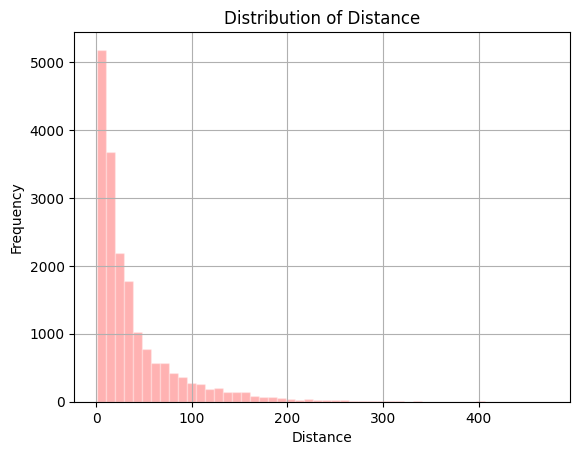

In [ ]:
import matplotlib.pyplot as plt

distance = damage_gun_df[damage_gun_df['distance'] < 5000]
plt.hist(distance['distance'], bins=50, alpha=0.3, color='red',edgecolor='White')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Distance')
plt.grid(True)
plt.show()



아무래도 장착된 방어구와 파츠에따라 반동을 얼마나 막아주고, 데미지가 감소하는지 영향이있다. 일단 고려하지 않은 상태에서 확인해 봅시다.

* 아래의 경우 특정 유저의 무기별 shot 과 hit 을 집계한것


In [ ]:
T = ['LogPlayerAttack','LogPlayerTakeDamage']
test = player_values[player_values['_T'].isin(T)][['_D','_T','attacker.name','damageTypeCategory','damage','damageReason','damageCauserName','weapon.itemId','distance']]

test = test.groupby(['attacker.name','_T','weapon.itemId',]).agg(
    log_count = pd.NamedAgg(column='_T',aggfunc='count'),
    # damage_sum = pd.NamedAgg(column='damage',aggfunc='sum')
    )

test

log_count
attacker.name _T                  weapon.itemId                  
jjining       LogPlayerAttack     Item_Weapon_AK47_C           14
                                  Item_Weapon_AUG_C            22
                                  Item_Weapon_Vector_C         30
              LogPlayerTakeDamage Item_Weapon_AK47_C            3
                                  Item_Weapon_AUG_C             2
                                  Item_Weapon_Vector_C          4

In [ ]:
# 치킨을 먹은 사람의 스탯이구나!
match_end_data = df[df['allWeaponStats'].notna()][['characters','allWeaponStats','gameResultOnFinished.results','GameMode','MapName','matchId']]
match_end_data['allWeaponStats'] = match_end_data['allWeaponStats'].apply(lambda x: json.loads(x.replace("'", '"')))


In [ ]:
match_end_data[['allWeaponStats','matchId']]

In [ ]:
test = match_end_data[['allWeaponStats','matchId']].to_json(orient='table')
parsed = json.loads(test)
chicken_stats = pd.json_normalize(data=parsed['data'],
                                  record_path=['allWeaponStats'],
                                  meta=['matchId'])
# chicken_stats

### chiken winner data

3중구조로 묶여있는 변수가 있었는데, 각 매치경기별 우승자들의 weapon 과 관련된 디테일한 정보였음.

* 모든 유저를 아래의 데이터프레임 처럼 전처리하면 좋을것 같음
* 거리에 관한 지표를 알 수 없는점이 좀 아깝다.
* 일단, 우승자의 Weapon details json풀어보면 아래와 같음

In [ ]:
for log in log:
    if 'allWeaponStats' in log:
        print(json.dumps(log, indent=2))

In [ ]:
test = chicken_stats.to_json(orient='table')
parsed = json.loads(test)
allWeapon = pd.json_normalize(data=parsed['data'],
                                  record_path=['stats'],
                                  meta=['matchId','accountId'])
allWeapon.head()

In [ ]:
# allWeapon['hitDetails'] 의 경우 빈 list 인 경우가 있다. shot 했지만 맞추지 못한 경우에 해당함

allWeapon['hitDetails'].tolist()[0]

[{'bodyPart': 'TorsoShot',
  'kills': 1,
  'dBNOs': 0,
  'hits': 2,
  'dBNOHits': 0,
  'damage': 39,
  'dBNODamage': 0},
 {'bodyPart': 'HeadShot',
  'kills': 0,
  'dBNOs': 0,
  'hits': 1,
  'dBNOHits': 0,
  'damage': 60,
  'dBNODamage': 0}]

In [ ]:
cols = ['weapon','damage','dBNODamage','shots','hits','dBNOHits','holdingTime','accountId','matchId']
allWeapon_json = allWeapon.to_json(orient='table')
parsed = json.loads(allWeapon_json)

hitDetails_df = pd.json_normalize(data=parsed['data'],
                                  record_path=['hitDetails'],
                                  meta=cols,
                                  record_prefix='w_'
                                  )
hitDetails_df.head()

w_bodyPart  w_kills  w_dBNOs  w_hits  w_dBNOHits  w_damage  w_dBNODamage  \
0  TorsoShot        1        0       2           0        39             0   
1   HeadShot        0        0       1           0        60             0   
2   HeadShot        1        0       2           0        66             0   
3    ArmShot        0        0       2           0        16             0   
4  TorsoShot        1        0       7           0        91             0   

             weapon damage dBNODamage shots hits dBNOHits holdingTime  \
0       WeapACE32_C    100          0     8    3        0         126   
1       WeapACE32_C    100          0     8    3        0         126   
2  WeapWinchester_C    175          0    18   11        0         523   
3  WeapWinchester_C    175          0    18   11        0         523   
4  WeapWinchester_C    175          0    18   11        0         523   

                                  accountId  \
0  account.a7611f8f6499492087abc7787bcc15ea   
1  account.a7611f8f6499492087abc7787bcc15ea   
2  account.a7611f8f6499492087abc7787bcc15ea   
3  account.a7611f8f6499492087abc7787bcc15ea   
4  account.a7611f8f6499492087abc7787bcc15ea   

                                matchId  
0  b4009b9a-28f1-4ff9-9f61-21a3def975bb  
1  b4009b9a-28f1-4ff9-9f61-21a3def975bb  
2  b4009b9a-28f1-4ff9-9f61-21a3def975bb  
3  b4009b9a-28f1-4ff9-9f61-21a3def975bb  
4  b4009b9a-28f1-4ff9-9f61-21a3def975bb

## 중간 정리
* 무기테이블을 어떻게 만들 것 인가? 그리고 어떤 컨텐츠가 필요한지 정리가 필요하다.

* 잠깐 일등한 유저의 데이터를 보느라 흐름이 끊겼지만, 내가 해야하는 분석을 되돌아 보면 다음과 같음

* 총별 거리 성능을 알 수 있는 지표
* 총별 반동 성능을 알 수 있는 지표

그리고 지금 거리와 관련된 지표를 구하고 있음.

In [ ]:
# 유저가 '거리'별로 얼마나 shot 하고 맞췃는지에 대해서 하나의 프레임으로 집계하려면 전처리가 필요한데..
# 하나의 유저로 예시 전처리를 해보쟈
# 초단위를 제외한 시간값 추가
player_values['_D'] = pd.to_datetime(player_values['_D']) #.dt.strftime('%Y-%m-%dT%H:%M:%S')

<ipython-input-12-59ab9adc6371>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_values['_D'] = pd.to_datetime(player_values['_D']) #.dt.strftime('%Y-%m-%dT%H:%M:%S')


In [ ]:
player_values[player_values['_T'] == 'LogPlayerTakeDamage']

_D                   _T character.name  \
945758  2024-05-22T12:03:32.934Z  LogPlayerTakeDamage            NaN   
945759  2024-05-22T12:03:32.934Z  LogPlayerTakeDamage            NaN   
945760  2024-05-22T12:03:32.934Z  LogPlayerTakeDamage            NaN   
945761  2024-05-22T12:03:32.935Z  LogPlayerTakeDamage            NaN   
945762  2024-05-22T12:03:32.935Z  LogPlayerTakeDamage            NaN   
945763  2024-05-22T12:03:32.935Z  LogPlayerTakeDamage            NaN   
945764  2024-05-22T12:03:32.936Z  LogPlayerTakeDamage            NaN   
945765  2024-05-22T12:03:32.936Z  LogPlayerTakeDamage            NaN   
945766  2024-05-22T12:03:32.936Z  LogPlayerTakeDamage            NaN   
945773  2024-05-22T12:03:33.200Z  LogPlayerTakeDamage            NaN   

        character.health  healAmount weaponId damageCauserName attacker.name  \
945758               NaN         NaN      NaN       WeapDP12_C   woooo_v0_0v   
945759               NaN         NaN      NaN       WeapDP12_C   woooo_v0_0v   
945760               NaN         NaN      NaN       WeapDP12_C   woooo_v0_0v   
945761               NaN         NaN      NaN       WeapDP12_C   woooo_v0_0v   
945762               NaN         NaN      NaN       WeapDP12_C   woooo_v0_0v   
945763               NaN         NaN      NaN       WeapDP12_C   woooo_v0_0v   
945764               NaN         NaN      NaN       WeapDP12_C   woooo_v0_0v   
945765               NaN         NaN      NaN       WeapDP12_C   woooo_v0_0v   
945766               NaN         NaN      NaN       WeapDP12_C   woooo_v0_0v   
945773               NaN         NaN      NaN       WeapDP12_C   woooo_v0_0v   

       attackType  attacker.health  attacker.location.x  attacker.location.y  \
945758        NaN        41.544201          236357.5625         79679.781250   
945759        NaN        41.544201          236357.5625         79679.781250   
945760        NaN        41.544201          236357.5625         79679.781250   
945761        NaN        41.544201          236357.5625         79679.781250   
945762        NaN        41.544201          236357.5625         79679.781250   
945763        NaN        41.544201          236357.5625         79679.781250   
945764        NaN        41.544201          236357.5625         79679.781250   
945765        NaN        41.544201          236357.5625         79679.781250   
945766        NaN        41.544201          236357.5625         79679.781250   
945773        NaN        41.544201          236326.9375         79691.960938   

        attacker.location.z damageTypeCategory     damage       weapon.itemId  \
945758           505.970001         Damage_Gun  10.530000  Item_Weapon_DP12_C   
945759           505.970001         Damage_Gun  10.003500  Item_Weapon_DP12_C   
945760           505.970001         Damage_Gun  10.003500  Item_Weapon_DP12_C   
945761           505.970001         Damage_Gun  10.530000  Item_Weapon_DP12_C   
945762           505.970001         Damage_Gun  10.003500  Item_Weapon_DP12_C   
945763           505.970001         Damage_Gun  10.530000  Item_Weapon_DP12_C   
945764           505.970001         Damage_Gun  10.003500  Item_Weapon_DP12_C   
945765           505.970001         Damage_Gun  10.530000  Item_Weapon_DP12_C   
945766           505.970001         Damage_Gun  10.530000  Item_Weapon_DP12_C   
945773           505.970001         Damage_Gun   7.335998  Item_Weapon_DP12_C   

        weapon.stackCount  fireWeaponStackCount victim.name damageReason  \
945758                NaN                   NaN  divertimon    TorsoShot   
945759                NaN                   NaN  divertimon    TorsoShot   
945760                NaN                   NaN  divertimon    TorsoShot   
945761                NaN                   NaN  divertimon    TorsoShot   
945762                NaN                   NaN  divertimon    TorsoShot   
945763                NaN                   NaN  divertimon    TorsoShot   
945764                NaN                   NaN  di

In [ ]:
attack_col = ['_D','_T','attacker.name','weapon.itemId','fireWeaponStackCount']
dmg_col = ['_D','_T','damageCauserName','attacker.name', 'damageTypeCategory','damage','weapon.itemId']#$'ArmShot',	'HeadShot',	'LegShot',	'PelvisShot',	'TorsoShot','distance'] # NonSpecific'

In [ ]:
# 유저가 무기별 사용한(shot) 데이터
weapon_shot = player_values[player_values['_T'] == 'LogPlayerAttack'][attack_col]
weapon_shot = weapon_shot.groupby(['attacker.name',pd.Grouper(key='_D', freq='10S'),'weapon.itemId']).agg(
    shot = pd.NamedAgg(column='_T',aggfunc='count')
).reset_index()
weapon_shot

attacker.name                        _D            weapon.itemId  shot
0  0-ZombieKilleR-0 2024-05-30 11:13:50+00:00  Item_Weapon_BerylM762_C    10
1  0-ZombieKilleR-0 2024-05-30 11:15:00+00:00  Item_Weapon_BerylM762_C     6
2  0-ZombieKilleR-0 2024-05-30 11:15:10+00:00  Item_Weapon_BerylM762_C     4
3  0-ZombieKilleR-0 2024-05-30 11:16:30+00:00      Item_Weapon_QBU88_C     1

In [ ]:
# 유저가 상대방을 맞췄을 때
weapon_hit = player_values[player_values['_T'] == 'LogPlayerTakeDamage']#[dmg_col]
weapon_hit = weapon_hit.groupby(['attacker.name',pd.Grouper(key='_D', freq='10S'),'weapon.itemId','victim.name']).agg(
    hit = pd.NamedAgg(column='_T',aggfunc='count'),
    distanceMean = pd.NamedAgg(column='distance',aggfunc='mean'),
).reset_index()
weapon_hit

attacker.name                        _D            weapon.itemId  \
0  0-ZombieKilleR-0 2024-05-30 11:13:50+00:00  Item_Weapon_BerylM762_C   

       victim.name  hit  distanceMean  
0  Hipster_hamster    4      6.740587

In [ ]:

# shot을 기준으로 merge 해야한다.
merged_df = pd.merge(weapon_shot, weapon_hit,
                     left_on=['attacker.name', '_D','weapon.itemId'],
                     right_on=['attacker.name', '_D','weapon.itemId'],
                     how='left')
merged_df[['hit']] = merged_df[['hit']].fillna(0)
merged_df

attacker.name                        _D            weapon.itemId  shot  \
0  0-ZombieKilleR-0 2024-05-30 11:13:50+00:00  Item_Weapon_BerylM762_C    10   
1  0-ZombieKilleR-0 2024-05-30 11:15:00+00:00  Item_Weapon_BerylM762_C     6   
2  0-ZombieKilleR-0 2024-05-30 11:15:10+00:00  Item_Weapon_BerylM762_C     4   
3  0-ZombieKilleR-0 2024-05-30 11:16:30+00:00      Item_Weapon_QBU88_C     1   

       victim.name  hit  distanceMean  
0  Hipster_hamster  4.0      6.740587  
1              NaN  0.0           NaN  
2              NaN  0.0           NaN  
3              NaN  0.0           NaN

* 맞춘 부위별 값들을 컬럼으로 merge

In [ ]:
# damageReason 값을 더미 변수로 변환, 컬럼으로 피봇하여 여부확인
damage_dummies = pd.get_dummies(damage_gun_df['damageReason'])
result_df = pd.concat([damage_gun_df, damage_dummies], axis=1)

In [ ]:
result_df.sample(10)

In [ ]:
damage_dummies.head()

In [ ]:
attack_col = ['_D','_T','attacker.name','weapon.itemId','fireWeaponStackCount']
dmg_col = ['_D','_T','damageCauserName','attacker.name', 'damageTypeCategory','damage','weapon.itemId','ArmShot',	'HeadShot',	'LegShot',	'PelvisShot',	'TorsoShot','distance','victim.name'] # NonSpecific'

# 모든 유저에 위 과정을 적용 시키면
# 초단위를 제외한 시간값 추가
result_df['_D'] = pd.to_datetime(result_df['_D']) #.dt.strftime('%Y-%m-%dT%H:%M:%S')

weapon_shot = result_df[result_df['_T'] == 'LogPlayerAttack'][attack_col]
weapon_shot = weapon_shot.groupby(['attacker.name',pd.Grouper(key='_D', freq='1S'),'weapon.itemId']).agg(
    shot = pd.NamedAgg(column='_T',aggfunc='count')
).reset_index()


weapon_hit = result_df[result_df['_T'] == 'LogPlayerTakeDamage'][dmg_col]
weapon_hit = weapon_hit.groupby(['attacker.name',pd.Grouper(key='_D', freq='1S'),'weapon.itemId','victim.name']).agg(
    hit = pd.NamedAgg(column='_T',aggfunc='count'),
    distanceMean = pd.NamedAgg(column='distance',aggfunc='mean'),
    ArmShot = pd.NamedAgg(column='ArmShot',aggfunc='sum'),
    HeadShot = pd.NamedAgg(column='HeadShot',aggfunc='sum'),
    LegShot = pd.NamedAgg(column='LegShot',aggfunc='sum'),
    PelvisShot = pd.NamedAgg(column='PelvisShot',aggfunc='sum'),
    TorsoShot = pd.NamedAgg(column='TorsoShot',aggfunc='sum'),
    # NonSpecific = pd.NamedAgg(column='NonSpecific', aggfunc='sum'),
    damage = pd.NamedAgg(column='damage',aggfunc='sum')
).reset_index()

# shot을 기준으로 merge 해야한다.
merged_df = pd.merge(weapon_shot, weapon_hit,
                    left_on=['attacker.name', '_D','weapon.itemId'],
                    right_on=['attacker.name', '_D','weapon.itemId'],
                    how='left')

bins = [i for i in range(0, 80, 10)] + [float('inf')]
labels = [f'{i}~{i+10}' for i in range(0, 70, 10)] + ['70 이상']

# 범주형 컬럼 생성
merged_df['distance_category'] = pd.cut(merged_df['distanceMean'], bins=bins, labels=labels, right=False)

In [ ]:
merged_df[['hit','ArmShot','HeadShot',	'LegShot',	'PelvisShot',	'TorsoShot','damage']] = merged_df[['hit','ArmShot','HeadShot',	'LegShot',	'PelvisShot',	'TorsoShot','damage']].fillna(0).astype(int)

In [ ]:
# 총기 장르 추가
merged_df['weapon.genre'] = [
    'AR' if item in AR else
    'DMR' if item in DMR else
    'SR' if item in SR else
    'SG' if item in SG else
    'SMG' if item in SMG else
    'LMG' if item in LMG else
    'Special' if item in Special else
    'Unknown'
    for item in merged_df['weapon.itemId']
]


In [ ]:
merged_df.head(19)

In [ ]:
sample = merged_df[merged_df['distanceMean'] < 500]

sample.groupby(['distance_category']).agg(
    hit = pd.NamedAgg(column='hit',aggfunc='sum'),
    shot = pd.NamedAgg(column='shot',aggfunc='sum'))

hit  shot
distance_category            
500미만              1677  4530
500~1000              0     0
1000~2000             0     0
2000~3000             0     0
3000~4000             0     0
4000~5000             0     0
5000~6000             0     0
6000~7000             0     0
7000~8000             0     0
8000~9000             0     0
9000~10000            0     0
10000 이상              0     0

In [ ]:
merged_df.head()

* 샷건의 경우, 한번 SHOT 해도 여러개의 탄환이 나가는걸 데이터에도 고증되어있음 ㄷㄷ, 그래서 ratio 가 100%를 넘어가는 경우가 있음 1번 shot 했지만 탄환은 2개 이상이 나가기 때문임
* 1초동안 n번 shot 하고 맞춘 경우 -> victim 의 위치와 차이를 구해서 구할 수 있음
* 하지만 shot 했지만 맞추지 못한 경우 거리를 구할 수가 없음, 어떤 적을보고 쐈는지 알 수 없기 때문이다.

여러 총들을 **거리별로 shot 했을 때 hit한 비율**을 구할 수 있음


 (물론 보정기나 부착아이템이라는 효과가 있겠지만 일단 고려하지 않고 구해보자)

In [ ]:
# 정확도 계산
col = ['weapon.genre','weapon.itemId','shot','hit','distanceMean','distance_category','ratio']
merged_df['ratio'] = merged_df['hit']*100 / merged_df['shot']
merged_df['miss'] = merged_df['shot'] - merged_df['hit']
merged_df[['ratio','distanceMean']] = merged_df[['ratio','distanceMean']].fillna(0).astype(int)


In [ ]:
merged_df.head()

In [ ]:
# 1초동안 shot을 5번이상한 경우
AR_df = merged_df[
    (merged_df['distanceMean'] >= 1) &
    (merged_df['distanceMean'] < 100) &
    (merged_df['shot'] >= 5) & (merged_df['weapon.genre'] =='AR')
    ]# [col] #shot_1000m # (merged_df['weapon.itemId'] == 'Item_Weapon_HK416_C')


In [ ]:
# 1초동안 5번이상 SHOT했을때, 총기들의 거리별 정확도
AR_hit_df = AR_df.groupby(['weapon.itemId','distance_category']).agg(

                        HeadShot = pd.NamedAgg(column='HeadShot', aggfunc='sum'),
                        ArmShot = pd.NamedAgg(column='ArmShot', aggfunc='sum'),
                        LegShot = pd.NamedAgg(column='LegShot', aggfunc='sum'),
                        PelvisShot = pd.NamedAgg(column='PelvisShot', aggfunc='sum'),
                        TorsoShot = pd.NamedAgg(column='TorsoShot', aggfunc='sum'),
                        shot = pd.NamedAgg(column='shot',aggfunc='sum'),
                        hit = pd.NamedAgg(column='hit',aggfunc='sum'),
                        ratio = pd.NamedAgg(column='ratio', aggfunc='mean'),

                        )
AR_hit_df[AR_hit_df['shot'] > 100]

HeadShot  ArmShot  LegShot  \
weapon.itemId           distance_category                               
Item_Weapon_ACE32_C     0~10                     15       28       29   
                        10~20                    20       37       36   
                        20~30                    19       17       35   
                        30~40                     9       19       41   
                        40~50                     3       11       14   
                        50~60                     6        6       11   
                        60~70                     2        1       11   
                        70 이상                     0        1        9   
Item_Weapon_AK47_C      0~10                     12       21       20   
                        10~20                    15       13       15   
                        20~30                     7       12       13   
                        30~40                     4        4        9   
                        40~50                     1        3        3   
                        50~60                     1        0        1   
Item_Weapon_AUG_C       0~10                     21       29       21   
                        10~20                    29       34       35   
                        20~30                    17       17       22   
                        30~40                    18       15       17   
                        40~50                     4        5        5   
                        50~60                     4        2        6   
                        60~70                     2        3        9   
                        70 이상                     1        3        1   
Item_Weapon_BerylM762_C 0~10                     27       33       44   
                        10~20                    28       25       55   
                        20~30                    22       22       53   
                        30~40                    13       19       33   
                        40~50                     8        7       19   
                        50~60                     4       11       13   
                        60~70                     3        2        5   
                        70 이상                     1        1       10   
Item_Weapon_FAMASG2_C   20~30                     3        4        3   
Item_Weapon_Groza_C     30~40                     0        0        4   
Item_Weapon_HK416_C     0~10                     23       22       33   
                        10~20                    16       17       39   
                        20~30                    20       30       29   
                        30~40                    15       18       23   
                        40~50                     7        8        9   
                        50~60                     7        3        5   
                        60~70                     4        2        3   
                        70 이상                     1        1        4   
Item_Weapon_M16A4_C     0~10                      2        1        3   
                        10~20                     1        4        2   
Item_Weapon_QBZ95_C     0~10                      6       18       26   
                        10~20                     9        9       19   
                        20~30                    10        7       13   
                        30~40                     6        7       24   
                        40~50                     4        0       10   
                        50~60                     2        4       10   
                        60~70                     1        0        2   
                        70 이상                     0        1        5   

                                           PelvisShot  TorsoShot  shot  hit  \
weapon.itemId           distance_category                                     
Item_Weapon_ACE32_C     0~10                       29        151  1228  252   
         

In [ ]:
diff = []
for itemId, group in AR_hit_df.groupby('weapon.itemId'):
    if len(group) > 0:

        weapon_itemId = group.iloc[0]['weapon.itemId']
        mean_ratio = group.iloc[-1]['mean_ratio']

        diff.append({
            'id': weapon_itemId,
            'data' : [{'x': distance_category, 'y': mean_ratio} for distance_category, mean_ratio in zip(group['distance_category'], group['mean_ratio'])],
        })


### 총기 부착물 전처리하기

In [ ]:
# dataframe 리스트 값이 문자 그 자체로 인식이 되어버린다 `[` `]` 까지.. 그래서  import ast 이용해야함
# 각 셀의 값을 리스트로 변환
import ast

def convert_to_list(cell_value):
    try:
        # 문자열을 파이썬 리스트로 변환
        list_value = ast.literal_eval(cell_value)
        return list_value
    except ValueError:
        # 변환이 실패하면 그대로 반환
        return cell_value

# 'col' 열의 각 값에 대해 변환 적용
damage_gun_df['killerDamageInfo.additionalInfo'] = damage_gun_df['killerDamageInfo.additionalInfo'].apply(convert_to_list)

<ipython-input-106-daea0f229bc4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  damage_gun_df['killerDamageInfo.additionalInfo'] = damage_gun_df['killerDamageInfo.additionalInfo'].apply(convert_to_list)


In [ ]:
# 모든 고유한 값들을 담을 빈 집합(set) 생성
unique_values = set()

# 각 행의 리스트에서 고유한 값들을 집합에 추가
for lst in test['killerDamageInfo.additionalInfo']:
    unique_values.update(lst)

# 집합을 리스트로 변환하여 고유한 값들을 포함한 리스트 생성
unique_values_list = list(unique_values)
unique_values_list

In [ ]:
# 리스트를 벗기고 문자열로 변환하는 함수 정의
def strip_list(lst):
    if isinstance(lst, list):
        return ', '.join(lst)
    else:
        return ''

# killerDamageInfo.additionalInfo 열의 리스트 벗기기
damage_gun_df['killerDamageInfo.additionalInfo'] = damage_gun_df['killerDamageInfo.additionalInfo'].apply(strip_list)


<ipython-input-110-e29b7e732099>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  damage_gun_df['killerDamageInfo.additionalInfo'] = damage_gun_df['killerDamageInfo.additionalInfo'].apply(strip_list)


### 부위별 총기 정확도

* (victim.name = Bear) 부위가 Nonspetific 인 경우, 몬스터를 맞춘 경우임
* (victim.health = 0 ) 인경우, 즉 시체를 맞춘 경우  damage가 0으로 집계된다. 시체를 쏘고 맞춰도 피해를 받았다는 로그는 남는다.

In [ ]:
damage_gun_df[(damage_gun_df['attacker.name'] == 'apor-boluo_ing') & (damage_gun_df['_T'] == 'LogPlayerTakeDamage')]

In [ ]:
# 1초동안 shot을 5번이상한 경우
AR_df = merged_df[
    (merged_df['distanceMean'] >= 1) &
    (merged_df['distanceMean'] < 50) &
    (merged_df['shot'] >= 5)
    ] # (merged_df['weapon.genre'] =='AR')


In [ ]:
AR_df.head(100)

## 반동에 대한 지표 전처리

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

In [ ]:
# 지도 이미지 추가
map_path = "/content/hitbox.png"
img = Image.open(map_path)

In [ ]:
def calculate_coordinates(row, hit_locations):
    coordinates = []
    for hit_type, (x, y) in hit_locations.items():
        coordinates.extend([(x, y)] * int(row[hit_type]))  # 정수로 변환하여 사용
    return coordinates

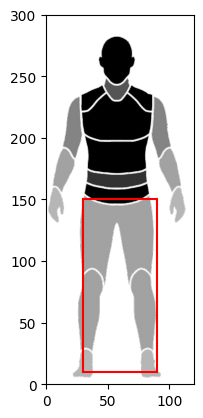

In [ ]:
# plt.axis('off')

fig, ax = plt.subplots()
ax.imshow(img, extent=[0, 150, 0, 300])
# Define range
head = [(40, 75, 240, 280)]
Toroso = [(30, 85, 175, 240)]
Arm = [(0,30,230,140),(90,120,230,140) ]
Pelvis  = [(30,90,150,175)]
Leg = [(30,90,10, 150)]
Miss = [(0, 20, 10, 120),
        (95, 120, 10, 120),
        (80, 120, 250, 300),
        (0, 40, 250, 300),
        ]

for x_start, x_end, y_start, y_end in Leg:
    x, y = np.meshgrid(np.arange(x_start, x_end, 1), np.arange(y_start, y_end, 1))

    x_flat = x.flatten()
    y_flat = y.flatten()

    coords_within_range = (x_flat >= x_start) & (x_flat <= x_end) & (y_flat >= y_start) & (y_flat <= y_end)

    # Add range rectangle to plot
    ax.plot([x_start, x_start], [y_start, y_end], 'r')
    ax.plot([x_start, x_end], [y_start, y_start], 'r')
    ax.plot([x_end, x_end], [y_start, y_end], 'r')
    ax.plot([x_start, x_end], [y_end, y_end], 'r')

# Set x and y limits
ax.set_xlim([0, 120])
ax.set_ylim([0, 300])

# Show plot
plt.show()

In [ ]:
beryl = AR_df[(AR_df['weapon.itemId'] =='Item_Weapon_BerylM762_C') & (AR_df['PelvisShot'] > 2)].sample(1)

beryl

attacker.name                        _D            weapon.itemId  shot  \
20235        noooSJ 2024-05-31 15:03:31+00:00  Item_Weapon_BerylM762_C     7   

      victim.name  hit  distanceMean  ArmShot  HeadShot  LegShot  PelvisShot  \
20235    LED_fire    6            12        0         0        0           3   

       TorsoShot  damage distance_category weapon.genre  ratio  miss  \
20235          3      99             10~20           AR     85     1   

                                         hit_coordinates  
20235  [{'x': 83.68350503011337, 'y': 202.99663134989...

<ipython-input-144-68d6042921ef>:25: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sc = ax.scatter(x_data, y_data, alpha=1, s=15, edgecolors='none',marker='x')


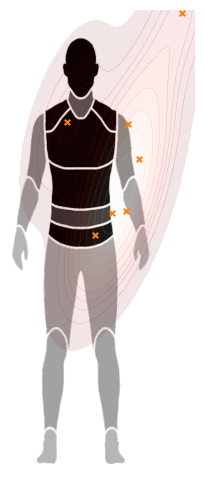

In [ ]:
import seaborn as sns


def death_spot2(df):
    x_data = []
    y_data = []
    for coords_list in df['hit_coordinates']:
        for coord in coords_list:
            x_data.append(coord['x'])
            y_data.append(coord['y'])

    # 그래프 그리기
    fig, ax = plt.subplots(figsize=(6, 6))
    # Set x and y limits
    ax.set_xlim([0, 120])
    ax.set_ylim([0, 300])
    plt.axis('off')

    ax.imshow(img, extent=[0, 120, 0, 300])  # Uncomment this line if you have an image to overlay

    # Seaborn의 kdeplot으로 음영 추가
    sns.kdeplot(x=x_data, y=y_data, shade=True, cmap='Reds_r', ax=ax, alpha=0.1)

    # matploltlib 산점도로 표시
    sc = ax.scatter(x_data, y_data, alpha=1, s=15, edgecolors='none',marker='x')

    plt.show()

# 함수 호출
death_spot2(beryl)

In [ ]:
import random

# 부위별 좌표 랜덤생성

hit_locations = {
    'HeadShot': [(40, 75, 240, 280)],
    'TorsoShot':[(30, 85, 175, 240)] ,
    'ArmShot': [(0,30,230,140),(90,120,230,140)],
    'PelvisShot': [(30,90,150,175)],
    'LegShot': [(30,90,10, 150)],
    'miss' : [(0, 20, 10, 120),
        (95, 120, 10, 120),
        (80, 120, 250, 300),
        (0, 40, 250, 300),
        ]

}
def generate_random_coordinates(hit_location_ranges):
    x1, x2, y1, y2 = hit_location_ranges
    x = random.uniform(x1, x2)
    y = random.uniform(y1, y2)
    return {'x': x, 'y': y}

def calculate_coordinates(row):
    coordinates = []
    for hit_type, ranges in hit_locations.items():
        num_hits = row[hit_type]
        for _ in range(num_hits):
            range_tuple = random.choice(ranges)  # 여러 범위 중 무작위로 하나 선택
            coord = generate_random_coordinates(range_tuple)
            coordinates.append(coord)
    return coordinates

# Apply calculate_coordinates function to each row in the DataFrame
AR_df['hit_coordinates'] = AR_df.apply(calculate_coordinates, axis=1)

<ipython-input-132-6c9586da88ad>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AR_df['hit_coordinates'] = AR_df.apply(calculate_coordinates, axis=1)


In [ ]:
# 랜덤 생성된 좌표들의 차이를 구한다음 평균을 구한다. -> 반동지표

def calculate_recoil(row):
    recoil_values = []
    prev_x = None
    prev_y = None
    for coord in row['hit_coordinates']:
        x = coord['x']
        y = coord['y']
        if prev_x is not None and prev_y is not None:
            # Calculate Euclidean distance between consecutive shots
            recoil = np.sqrt((x - prev_x)**2 + (y - prev_y)**2)
            recoil_values.append(recoil)
        prev_x = x
        prev_y = y
    # Return mean recoil value
    if recoil_values:
        return np.mean(recoil_values)
    else:
        return np.nan

    return recoil_values

AR_df['recoil'] = AR_df.apply(calculate_recoil, axis=1)


In [ ]:
AR_df[AR_df['weapon.itemId'] =='Item_Weapon_BerylM762_C']

attacker.name                        _D            weapon.itemId  \
0      0-ZombieKilleR-0 2024-05-30 11:13:50+00:00  Item_Weapon_BerylM762_C   
174          0hyeonmin8 2024-05-23 14:10:37+00:00  Item_Weapon_BerylM762_C   
259            1000_RPM 2024-05-23 14:16:51+00:00  Item_Weapon_BerylM762_C   
524             1ee_m_g 2024-05-23 04:06:46+00:00  Item_Weapon_BerylM762_C   
1359          Abu-00544 2024-05-25 10:29:38+00:00  Item_Weapon_BerylM762_C   
1598      AngBodleBodle 2024-05-30 11:07:07+00:00  Item_Weapon_BerylM762_C   
2095          BBak_inho 2024-06-01 12:18:36+00:00  Item_Weapon_BerylM762_C   
2288          BLISS_DOL 2024-05-25 08:18:58+00:00  Item_Weapon_BerylM762_C   
2889          CPYANG316 2024-05-25 07:42:25+00:00  Item_Weapon_BerylM762_C   
2891          CPYANG316 2024-05-25 07:44:39+00:00  Item_Weapon_BerylM762_C   
2940          CXGNAC-_- 2024-05-22 12:40:13+00:00  Item_Weapon_BerylM762_C   
3506           DAETTANK 2024-05-24 12:55:28+00:00  Item_Weapon_BerylM762_C   
3963       Dont_Hacking 2024-05-24 12:43:14+00:00  Item_Weapon_BerylM762_C   
4782              GJB_A 2024-05-24 12:45:05+00:00  Item_Weapon_BerylM762_C   
5144          GangstarJ 2024-05-25 08:35:00+00:00  Item_Weapon_BerylM762_C   
5830            HYNN___ 2024-06-01 12:15:14+00:00  Item_Weapon_BerylM762_C   
6112        Hwangwoobin 2024-05-25 08:22:28+00:00  Item_Weapon_BerylM762_C   
6686     Im_not_haedaru 2024-05-30 11:24:37+00:00  Item_Weapon_BerylM762_C   
7520            KDRJSNF 2024-05-25 07:22:31+00:00  Item_Weapon_BerylM762_C   
8236            KSREMIR 2024-05-25 08:09:00+00:00  Item_Weapon_BerylM762_C   
8555       Kim_SangHyak 2024-05-23 14:28:26+00:00  Item_Weapon_BerylM762_C   
9077         L7L7_Aaeen 2024-05-23 09:21:09+00:00  Item_Weapon_BerylM762_C   
9181          LEEEEEJY_ 2024-05-24 11:57:04+00:00  Item_Weapon_BerylM762_C   
9364            LYB1376 2024-05-30 11:24:37+00:00  Item_Weapon_BerylM762_C   
9786          MINSU1220 2024-05-23 09:12:36+00:00  Item_Weapon_BerylM762_C   
10096          MarceR13 2024-05-31 15:03:02+00:00  Item_Weapon_BerylM762_C   
10771    Ni_Jeojtaeng_2 2024-05-24 12:43:16+00:00  Item_Weapon_BerylM762_C   
10868  Nowon_WidowMaker 2024-05-30 11:10:46+00:00  Item_Weapon_BerylM762_C   
11190        PIGTAEHOON 2024-05-23 09:46:41+00:00  Item_Weapon_BerylM762_C   
11804    QiaFanXiaoYang 2024-05-24 12:48:31+00:00  Item_Weapon_BerylM762_C   
12181         Re_VeIvet 2024-05-25 08:13:09+00:00  Item_Weapon_BerylM762_C   
12403            Ruhen_ 2024-05-30 11:12:48+00:00  Item_Weapon_BerylM762_C   
12406            Ruhen_ 2024-05-30 11:15:06+00:00  Item_Weapon_BerylM762_C   
13936            TAKU__ 2024-05-25 07:33:50+00:00  Item_Weapon_BerylM762_C   
14167         Teave_KOR 2024-05-23 14:13:09+00:00  Item_Weapon_BerylM762_C   
14825  Upliftmotfoparty 2024-05-25 01:19:02+00:00  Item_Weapon_BerylM762_C   
14848  Upliftmotfoparty 2024-05-25 01:37:42+00:00  Item_Weapon_BerylM762_C   
14919            VIO-13 2024-05-25 08:21:29+00:00  Item_Weapon_BerylM762_C   
15494             Xgaag 2024-05-25 08:23:45+00:00  Item_Weapon_BerylM762_C   
15916          ZipBbang 2024-05-25 08:15:57+00:00  Item_Weapon_BerylM762_C   
15944          ZipBbang 2024-05-25 08:30:50+00:00  Item_Weapon_BerylM762_C   
17596      boooooo123ji 2024-05-25 08:34:53+00:00  Item_Weapon_BerylM762_C   
19564      dpdltmahxjtm 2024-05-25 07:33:56+00:00  Item_Weapon_BerylM762_C   
20165      ggLggLggLggL 2024-05-23 08:18:41+00:00  Item_Weapon_BerylM762_C   
21300           hune159 2024-05-30 11:08:43+00:00  Item_Weapon_BerylM762_C   
21480        hyunystlye 2024-05-24 12:04:07+00:00  Item_Weapon_BerylM762_C   
21669  illiiliillililli 2024-05-23 14:17:23+00:00  Item_Weapon_BerylM762_C   
21675        illwoo0228 2024-05-31 14:59:59+00:00  Item_Weapon_BerylM762_C   
21827      incubers0423 2024-05-30 11:17:15+00:00  Item_Weapon_BerylM762_C   
22473     jungihong8323 2024-05-25 06:33:45+00:00  Item_Weapon_BerylM762_C   
22649       junseo__007 2024-06-

In [ ]:
AR_recoil = AR_df.groupby(['weapon.genre','weapon.itemId']).agg(
    recoil = pd.NamedAgg(column='recoil',aggfunc='mean'),
    shot = pd.NamedAgg(column='shot',aggfunc='sum'),
    hit = pd.NamedAgg(column='hit',aggfunc='sum')
).sort_values(by=['weapon.genre','recoil'],ascending=True).reset_index() # [AR_df['ratio']>40]

In [ ]:
AR_recoil

### 5초이내의 킬로그? 기절로그?

duo 매치의 경우, 상대팀이 두명 이상이므로한명을 죽여도 바로 게임이 끝나지 않기 때문에 Groogy, 기절상태의 로그가 추가된다.  
한 팀의 한 명이 이미 기절한 상태에서 나머지 한 명이 죽으면 기절한 팀원도 함께 죽기 때문에, 킬로그가 좀 꼬인다..

In [21]:
multikill = damage_gun_df[damage_gun_df['_T'].isin(['LogPlayerKillV2'])][['matchId','_D','_T','victim.name','victimWeapon','victimWeaponAdditionalInfo',
                                                                                                'attacker.name','attackType','attacker.health','attacker.location.x', 'attacker.location.y','attacker.location.z','damageTypeCategory','damage','weapon.itemId','weapon.stackCount','fireWeaponStackCount',
                                                                      'dBNOMaker.name','dBNODamageInfo.damageReason','dBNODamageInfo.damageTypeCategory','dBNODamageInfo.damageCauserName','dBNODamageInfo.additionalInfo','dBNODamageInfo.distance',
                                                                    'killerDamageInfo.distance','killer.name','killerDamageInfo.damageReason','killerDamageInfo.damageCauserName','killerDamageInfo.additionalInfo']].sort_values(by=['victim.name'])



multikill['killerDamageInfo.distance'] = multikill['killerDamageInfo.distance'] / 100                                                                 #,'LogPlayerMakeGroggy'


In [28]:
multikill[multikill['killer.name'] == 'WY53770'][['matchId','_D','_T','killer.name','victim.name', 'killerDamageInfo.damageCauserName','killerDamageInfo.distance']].sort_values(by=['_D'])


matchId                        _D  \
370372  14f4fa24-0874-4788-9f9a-015a57183b65  2024-06-01T12:15:51.552Z   
370431  14f4fa24-0874-4788-9f9a-015a57183b65  2024-06-01T12:15:52.755Z   
370561  14f4fa24-0874-4788-9f9a-015a57183b65  2024-06-01T12:15:55.192Z   
370835  14f4fa24-0874-4788-9f9a-015a57183b65  2024-06-01T12:16:00.034Z   
370980  14f4fa24-0874-4788-9f9a-015a57183b65  2024-06-01T12:16:02.273Z   
380521  14f4fa24-0874-4788-9f9a-015a57183b65  2024-06-01T12:22:37.502Z   
383124  14f4fa24-0874-4788-9f9a-015a57183b65  2024-06-01T12:25:18.828Z   

                     _T killer.name      victim.name  \
370372  LogPlayerKillV2     WY53770  ganjang_ch1cken   
370431  LogPlayerKillV2     WY53770      LILLAMAS_YM   
370561  LogPlayerKillV2     WY53770          shard_k   
370835  LogPlayerKillV2     WY53770         csil69kr   
370980  LogPlayerKillV2     WY53770     Sexyminjae__   
380521  LogPlayerKillV2     WY53770   Sweet_Baby_36D   
383124  LogPlayerKillV2     WY53770        whhhhhdsm   

       killerDamageInfo.damageCauserName  killerDamageInfo.distance  
370372                       WeapACE32_C                  25.512451  
370431                       WeapACE32_C                  28.982749  
370561                       WeapACE32_C                  43.946831  
370835                       WeapACE32_C                  28.819761  
370980                       WeapACE32_C                  22.526001  
380521                    WeapDragunov_C                 109.583564  
383124                       WeapACE32_C                  29.429016

In [34]:
multikill['_D'] = pd.to_datetime(multikill['_D']) #.dt.strftime('%Y-%m-%dT%H:%M:%S')
# 유저별로 그룹화
grouped = multikill.groupby(['matchId','killer.name']) # '_T','killer.name',

# weapon_kill = multikill.groupby(['killer.name',pd.Grouper(key='_D', freq='5S'),'killerDamageInfo.damageCauserName']).agg(
#     multikill = pd.NamedAgg(column='_T',aggfunc='count')
# ).reset_index()


In [11]:

# 10초 이내에 킬을 했는지 확인하는 함수
def check_kill_within_10_seconds(group):
    group = group.sort_values('_D')  # 타임스탬프 기준으로 정렬
    group['time_diff'] = group['_D'].diff().dt.total_seconds()   # 시간 차이 계산
    group['time_diff'].fillna(0, inplace=True) # 첫킬은 0으로

    # 인덱스가 2개 이상인 데이터만 필터링
    if len(group) >= 2:
        group['kill_log_count'] = len(group)
        return group
    else:
        return None  # 2개 이상인 데이터가 없으면 None 반환

# 각 그룹에 대해 함수 적용하여 필터링
filtered_groups = grouped.apply(check_kill_within_10_seconds)

In [39]:

# 10초 이내에 킬을 했는지 확인하는 함수
def check_kill_within_10_seconds(group):
    group = group.sort_values('_D')  # 타임스탬프 기준으로 정렬
    group['time_diff'] = group['_D'].diff().dt.total_seconds()  # 시간 차이 계산
    group['time_diff'].fillna(0, inplace=True)  # 첫킬은 0으로

    # 멀티킬 여부 판단
    group['multikill'] = 0
    if len(group) >= 2:
        group['multikill'] = (group['time_diff'] <= 5).astype(int) # true,false로 반환되는 값을 int 형으로 바꾼다. 1,0
        group.loc[group.index[0], 'multikill'] = 0  # 첫 킬은 멀티킬이 아님
    group['kill_log_count'] = len(group)

    return group

# 각 그룹에 대해 함수 적용하여 필터링
df_with_check = grouped.apply(check_kill_within_10_seconds).reset_index(drop=True)

result = df_with_check[['matchId','_D','time_diff','killer.name', 'killerDamageInfo.damageCauserName', 'multikill','killerDamageInfo.distance']]

In [ ]:
result[result['multikill']==1]

In [40]:
df_with_check[df_with_check['killer.name'] == 'WY53770'][['matchId','_D','time_diff','_T','killer.name', 'killerDamageInfo.damageCauserName', 'multikill','killerDamageInfo.distance']]
# df_with_check

matchId                               _D  \
229  14f4fa24-0874-4788-9f9a-015a57183b65 2024-06-01 12:15:51.552000+00:00   
230  14f4fa24-0874-4788-9f9a-015a57183b65 2024-06-01 12:15:52.755000+00:00   
231  14f4fa24-0874-4788-9f9a-015a57183b65 2024-06-01 12:15:55.192000+00:00   
232  14f4fa24-0874-4788-9f9a-015a57183b65 2024-06-01 12:16:00.034000+00:00   
233  14f4fa24-0874-4788-9f9a-015a57183b65 2024-06-01 12:16:02.273000+00:00   
234  14f4fa24-0874-4788-9f9a-015a57183b65 2024-06-01 12:22:37.502000+00:00   
235  14f4fa24-0874-4788-9f9a-015a57183b65 2024-06-01 12:25:18.828000+00:00   

     time_diff               _T killer.name killerDamageInfo.damageCauserName  \
229      0.000  LogPlayerKillV2     WY53770                       WeapACE32_C   
230      1.203  LogPlayerKillV2     WY53770                       WeapACE32_C   
231      2.437  LogPlayerKillV2     WY53770                       WeapACE32_C   
232      4.842  LogPlayerKillV2     WY53770                       WeapACE32_C   
233      2.239  LogPlayerKillV2     WY53770                       WeapACE32_C   
234    395.229  LogPlayerKillV2     WY53770                    WeapDragunov_C   
235    161.326  LogPlayerKillV2     WY53770                       WeapACE32_C   

     multikill  killerDamageInfo.distance  
229          0                  25.512451  
230          1                  28.982749  
231          1                  43.946831  
232          1                  28.819761  
233          1                  22.526001  
234          0                 109.583564  
235          0                  29.429016

In [ ]:
multikill_df= result[result['multikill']==1].groupby(['matchId','killer.name','killerDamageInfo.damageCauserName']).agg(
    multikill = pd.NamedAgg(column='multikill',aggfunc='sum'),
).reset_index()

# 첫번째 킬(0)이후 (더블킬)부터 집계(+1)가 되므로 1을 더해줘야 정확한 연속킬을 알 수 있음 (첫번째 킬을 포함해야함)
multikill_df['multikill_cnt'] = multikill_df['multikill'] + 1
multikill_df['multikill'] = 1
# 가령, WY53770 유저의 경우 10초안에 5명을 처치한 것으로 볼 수 있다.

multikill_static = multikill_df.groupby(['killerDamageInfo.damageCauserName']).agg({'multikill':'sum','multikill_cnt':'sum'}).reset_index()
multikill_static

killerDamageInfo.damageCauserName  multikill  multikill_cnt
0                        WeapACE32_C          8             19
1                         WeapAK47_C          7             14
2                          WeapAUG_C          4              8
3                   WeapBerreta686_C          1              2
4                    WeapBerylM762_C          5             10
5                         WeapDP12_C          2              4
6                     WeapDragunov_C          5             11
7                        WeapFNFal_C          1              2
8                      WeapFamasG2_C          1              2
9                        WeapHK416_C          3              6
10                         WeapJS9_C          2              4
11                      WeapKar98k_C          1              3
12                       WeapM16A4_C          1              2
13                        WeapM249_C          1              2
14                         WeapM24_C          1              2
15                      WeapMini14_C          1              2
16                        WeapMk12_C          2              4
17                  WeapMk47Mutant_C          3              6
18                       WeapQBU88_C          2              4
19                       WeapQBZ95_C          6             13
20                         WeapSKS_C          2              6
21                     WeapSaiga12_C          4              8
22                    WeapThompson_C          1              2
23                         WeapUMP_C          3              6
24                         WeapUZI_C          3              6
25                         WeapVSS_C          1              2
26                      WeapVector_C          3              6
27                  WeapWinchester_C          2              4

user weapon multikill \
A     AUG     o

In [ ]:
filtered_groups[(filtered_groups['killer.name'] == 'oe9339')][['_D','_T','killer.name','victim.name','killerDamageInfo.damageCauserName','time_diff','time_diff_cumsum','kill_log_count']]

_D  \
matchId                              killer.name                                            
17b6684d-5348-43ed-a237-1935a7a7336d oe9339      1039612 2024-05-23 08:14:23.323000+00:00   
                                                 1042259 2024-05-23 08:18:49.763000+00:00   
                                                 1043264 2024-05-23 08:20:57.904000+00:00   
                                                 1043308 2024-05-23 08:21:03.148000+00:00   

                                                                       _T  \
matchId                              killer.name                            
17b6684d-5348-43ed-a237-1935a7a7336d oe9339      1039612  LogPlayerKillV2   
                                                 1042259  LogPlayerKillV2   
                                                 1043264  LogPlayerKillV2   
                                                 1043308  LogPlayerKillV2   

                                                         killer.name  \
matchId                              killer.name                       
17b6684d-5348-43ed-a237-1935a7a7336d oe9339      1039612      oe9339   
                                                 1042259      oe9339   
                                                 1043264      oe9339   
                                                 1043308      oe9339   

                                                         victim.name  \
matchId                              killer.name                       
17b6684d-5348-43ed-a237-1935a7a7336d oe9339      1039612    WTVNepOZ   
                                                 1042259   gotna1213   
                                                 1043264    JDQS0_77   
                                                 1043308   Jer_ryKSG   

                                                         killerDamageInfo.damageCauserName  \
matchId                              killer.name                                             
17b6684d-5348-43ed-a237-1935a7a7336d oe9339      1039612                       WeapHK416_C   
                                                 1042259                       WeapHK416_C   
                                                 1043264                         WeapM24_C   
                                                 1043308                         WeapM24_C   

                                                          time_diff  \
matchId                              killer.name                      
17b6684d-5348-43ed-a237-1935a7a7336d oe9339      1039612      0.000   
                                                 1042259    266.440   
                                                 1043264    128.141   
                                                 1043308      5.244   

                                                          time_diff_cumsum  \
matchId                              killer.name                             
17b6684d-5348-43ed-a237-1935a7a7336d oe9339      1039612             0.000   
                                                 1042259           266.440   
                                                 1043264           394.581   
                                                 1043308           399.825   

                                                          kill_log_count  
matchId                              killer.name                          
17b6684d-5348-43ed-a237-1935a7a7336d oe9339      1039612               4  
                                                 1042259               4  
                                                 1043264               4  
                                                 1043308               4

In [ ]:
weapon_kill_df = damage_gun_df[damage_gun_df['_T'] == 'LogPlayerKillV2'].groupby(['killerDamageInfo.damageCauserName']).agg(
    total_kill_cnt = pd.NamedAgg(column='killerDamageInfo.damageCauserName',aggfunc='count'),
).reset_index()

# prompt: weapon_kill_df 와  multikill_static 를 merge 해주세요 (multikill_static 를 기준으로 , key는 killerDamageInfo.damageCauserName 입니다.)
merged_df = pd.merge(weapon_kill_df, multikill_static, on='killerDamageInfo.damageCauserName')


In [ ]:
# 10초이내에 달성한 킬 비율 by weapon
merged_df['ratio'] = merged_df['multikill_cnt'] * 100/ merged_df['total_kill_cnt']
merged_df[merged_df['total_kill_cnt'] >= 100].sort_values(by='ratio',ascending=False)

killerDamageInfo.damageCauserName  total_kill_cnt  multikill  \
6                     WeapDragunov_C             135          5   
21                     WeapSaiga12_C             103          4   
19                       WeapQBZ95_C             210          6   
1                         WeapAK47_C             271          7   
23                         WeapUMP_C             121          3   
0                        WeapACE32_C             401          8   
20                         WeapSKS_C             132          2   
16                        WeapMk12_C             106          2   
2                          WeapAUG_C             301          4   
26                      WeapVector_C             238          3   
4                    WeapBerylM762_C             398          5   
9                        WeapHK416_C             278          3   
7                        WeapFNFal_C             114          1   
14                         WeapM24_C             154          1   

    multikill_cnt     ratio  
6              11  8.148148  
21              8  7.766990  
19             13  6.190476  
1              14  5.166052  
23              6  4.958678  
0              19  4.738155  
20              6  4.545455  
16              4  3.773585  
2               8  2.657807  
26              6  2.521008  
4              10  2.512563  
9               6  2.158273  
7               2  1.754386  
14              2  1.298701

In [ ]:
# df_with_check[['_D','_T','killer.name','victim.name','weapon.itemId','time_diff']]
filtered_groups[(filtered_groups['time_diff'] > 0) & (filtered_groups['time_diff_cumsum'] < 11)][['_D','_T','killer.name','victim.name',
                                                                                                         'killerDamageInfo.damageCauserName','time_diff',
                                                                                                         'time_diff_cumsum']]#.reset_index(drop=True).sort_values(by=['killer.name','_D'],ascending =True)

_D  \
matchId                              killer.name                                                
14c9de95-7280-4edc-86ab-522edd164ec1 kingsaegung     608911  2024-05-23 09:29:24.233000+00:00   
14f4fa24-0874-4788-9f9a-015a57183b65 WE--LBWNB       373055  2024-06-01 12:16:50.972000+00:00   
                                     WY53770         370431  2024-06-01 12:15:52.755000+00:00   
                                                     370561  2024-06-01 12:15:55.192000+00:00   
                                                     370835  2024-06-01 12:16:00.034000+00:00   
                                                     370980  2024-06-01 12:16:02.273000+00:00   
                                     forlast         376617  2024-06-01 12:19:02.137000+00:00   
19392946-f5ae-42ac-95ee-ab7959123af7 IPS_0603        853648  2024-05-24 12:05:59.077000+00:00   
                                     flying_skrr     854264  2024-05-24 12:06:14.677000+00:00   
1a8c8071-b88f-4482-a573-ebabc61fc791 AngBodleBodle   341283  2024-05-30 11:07:14.840000+00:00   
                                     Z-Z_king        342629  2024-05-30 11:07:32.324000+00:00   
                                     ni-ga12         342534  2024-05-30 11:07:31.252000+00:00   
23f5ff53-900b-4a49-922b-9c31e8250f9c hyunbin725      199797  2024-05-31 14:59:21.666000+00:00   
28dc78e6-ba81-43da-96ed-f2b787b31da1 LUOZEYU_33      470805  2024-05-25 01:19:02.331000+00:00   
                                     MUZISUNGDRIBLE  482857  2024-05-25 01:26:47.255000+00:00   
2bb99169-55ce-4eff-a00c-109790cd65ce dodododo000111  1032830 2024-05-25 07:02:09.682000+00:00   
325511c1-ffe9-4d88-9c03-521f3955a0bb Cokeya          881237  2024-05-25 08:09:12.905000+00:00   
326031a5-3b4a-4e20-88a9-9c6d9fbab24c BLISS_DOL       124860  2024-05-25 08:12:28.019000+00:00   
3536683d-739a-40a8-8817-5d284432cfb0 Jamon2          815318  2024-05-24 12:43:17.874000+00:00   
356b9b1f-9074-485f-b950-a9eb8e3a544c yays02          703643  2024-05-24 13:00:01.089000+00:00   
4640c5bb-8c94-42f9-98c1-51143a6838a5 Lab_hater       1088721 2024-05-25 01:37:26.561000+00:00   
                                     OinxuanVzb      1082282 2024-05-25 01:32:36.065000+00:00   
468758fb-d113-44ea-b98f-0d8c89960fac BK_overload     313976  2024-05-30 11:12:24.503000+00:00   
5a50e06a-a30f-4470-9b1a-38a82797eb97 sjrjaotlstndo   787802  2024-05-25 08:02:54.253000+00:00   
60ea7d05-451a-4cc5-aff9-69e0523d8c4b JING1_003       587262  2024-05-24 12:49:52.099000+00:00   
77666dcb-5b98-4926-8f8f-7a86db27f363 SOLOLIFE        768744  2024-05-25 06:57:25.875000+00:00   
873db74a-e3e6-4e30-b48e-0db9ef177d3e Guard           1053011 2024-05-23 04:11:01.954000+00:00   
                                     uls_an000       1056694 2024-05-23 04:12:42.902000+00:00   
8b38d7bb-d63e-4932-b7db-77663f593d15 Tufer0          394778  2024-05-23 09:42:08.396000+00:00   
8c7c8102-50bf-44c9-b2f2-df7b4f060b8c KrAFTV_HWAN     257145  2024-05-22 12:19:25.780000+00:00   
8f97e0a5-0b12-41e7-a00f-9d9c37926c91 VeryGodBoyz     678369  2024-05-24 11:56:43.195000+00:00   
                                     bo5me           678342  2024-05-24 11:56:42.872000+00:00   
9f8cd136-1ce5-4ac9-86aa-1e038844690f rjsgmltlqkf     32573   2024-05-24 12:23:53.665000+00:00   
afe57d43-b1c4-410f-9536-519dafa8666e KDRJSNF         960634  2024-05-25 07:33:17.029000+00:00   
                                     qrtweoiahjf     961714  2024-05-25 07:33:30.670000+00:00   
b4009b9a-28f1-4ff9-9f61-21a3def975bb 877FA-K9_Drive  5721    2024-05-25 08:18:42.975000+00:00   
                                     Hwangwoobin     9937    2024-05-25 08:19:51.878000+00:00   
b9486659-c048-4891-8698-e3fe5970c2ea Wootheng        515307  2024-05-25 10:29:22.049000+00:00   
                                     yourmotherboz1  514088  2024-05-25 10:29:02.840000+00:00   
bd332405-d8f3-4b3b-95a8-605c8f184b07 seongyoong      552501  2024-05-23 04:35:49.385000+00:00   
c3b88d81-b5a5-4c6

In [ ]:
df_with_check.head()

matchId  \
matchId                              killer.name                                                   
0389c5f9-4deb-4a43-a2db-9887d015441f AFTV_SooHaeN   441486  0389c5f9-4deb-4a43-a2db-9887d015441f   
                                     BAELIN_222     439905  0389c5f9-4deb-4a43-a2db-9887d015441f   
                                                    441571  0389c5f9-4deb-4a43-a2db-9887d015441f   
                                                    447383  0389c5f9-4deb-4a43-a2db-9887d015441f   
                                     Elzabeth_Olsen 449328  0389c5f9-4deb-4a43-a2db-9887d015441f   

                                                                                         _D  \
matchId                              killer.name                                              
0389c5f9-4deb-4a43-a2db-9887d015441f AFTV_SooHaeN   441486 2024-05-23 09:08:31.598000+00:00   
                                     BAELIN_222     439905 2024-05-23 09:08:07.003000+00:00   
                                                    441571 2024-05-23 09:08:32.771000+00:00   
                                                    447383 2024-05-23 09:10:38.695000+00:00   
                                     Elzabeth_Olsen 449328 2024-05-23 09:11:45.070000+00:00   

                                                                         _T  \
matchId                              killer.name                              
0389c5f9-4deb-4a43-a2db-9887d015441f AFTV_SooHaeN   441486  LogPlayerKillV2   
                                     BAELIN_222     439905  LogPlayerKillV2   
                                                    441571  LogPlayerKillV2   
                                                    447383  LogPlayerKillV2   
                                     Elzabeth_Olsen 449328  LogPlayerKillV2   

                                                              victim.name  \
matchId                              killer.name                            
0389c5f9-4deb-4a43-a2db-9887d015441f AFTV_SooHaeN   441486   Broccoli_221   
                                     BAELIN_222     439905  angelshuiji_n   
                                                    441571   AFTV_SooHaeN   
                                                    447383        nakta_3   
                                     Elzabeth_Olsen 449328     INTOFLA_ME   

                                                            victimWeapon  \
matchId                              killer.name                           
0389c5f9-4deb-4a43-a2db-9887d015441f AFTV_SooHaeN   441486  WeapAK47_C_2   
                                     BAELIN_222     439905  WeapAK47_C_3   
                                                    441571   WeapUMP_C_5   
                                                    447383  WeapM249_C_1   
                                     Elzabeth_Olsen 449328  WeapAUG_C_19   

                                                                                   victimWeaponAdditionalInfo  \
matchId                              killer.name                                                                
0389c5f9-4deb-4a43-a2db-9887d015441f AFTV_SooHaeN   441486                                                 []   
                                     BAELIN_222     439905                                                 []   
                                                    441571                                                 []   
                                                    447383  ['Item_Attach_Weapon_Upper_Aimpoint_C', 'Item_...   
                                     Elzabeth_Olsen 449328                                                 []   

                                                           attacker.name  \
matchId                              killer.name                           
0389c5f9-4deb-4a43-a2db-9887d015441f AFTV_SooHaeN   441486           NaN   
                                     BAELIN_222     439905           NaN   

In [ ]:
import ast

sample = kill_df[(kill_df['_T'] =='LogPlayerKillV2') & (kill_df['killer.name'] =='Bs_gimozi')][['_D','_T','killer.name','killerDamageInfo.additionalInfo']]
sample['killerDamageInfo.additionalInfo'] = sample['killerDamageInfo.additionalInfo'].apply(ast.literal_eval)
sample = sample['killerDamageInfo.additionalInfo'].apply(pd.Series)
sample

0  \
1111800      Item_Attach_Weapon_Upper_Scope6x_C   
1111804  Item_Attach_Weapon_Upper_DotSight_01_C   
1131833  Item_Attach_Weapon_Upper_DotSight_01_C   
1131838      Item_Attach_Weapon_Upper_Scope6x_C   

                                                    1  \
1111800  Item_Attach_Weapon_Magazine_Extended_Large_C   
1111804           Item_Attach_Weapon_Lower_Foregrip_C   
1131833           Item_Attach_Weapon_Lower_Foregrip_C   
1131838  Item_Attach_Weapon_Magazine_Extended_Large_C   

                                                         2  \
1111800  Item_Attach_Weapon_Muzzle_Compensator_SniperRi...   
1111804       Item_Attach_Weapon_Muzzle_FlashHider_Large_C   
1131833       Item_Attach_Weapon_Muzzle_FlashHider_Large_C   
1131838  Item_Attach_Weapon_Muzzle_Compensator_SniperRi...   

                                                       3  
1111800  Item_Attach_Weapon_Stock_SniperRifle_CheekPad_C  
1111804     Item_Attach_Weapon_Magazine_Extended_Large_C  
1131833     Item_Attach_Weapon_Magazine_Extended_Large_C  
1131838  Item_Attach_Weapon_Stock_SniperRifle_CheekPad_C

# (기습) 3배 배그 지표정리

### 왁타버스 기여도 tmi
* 데미지를 가장 많이 입힌 사람 (damage_gun_type)
* 왁타버스 헤드헌터 (헤드샷 비율이 가장 좋은 사람)
* 왁타버스 명사수 (장거리에서 피해를 가장 많이 입힌 사람)
* 왁타버스 마라토너 (가장 많이 걸은 사람)
* 절약왕 (총을 가장 적게쏜 사람)
* 쿠키의집상 (부동산 운이 좋은사람)
* 노잼사왕 (총에 맞은 피해보다, 블루존, 레드존, 익사, Vehicle, 낙사등에 의한 피해량이 많은 사람)
* 황금 고블린상 (파밍로그가 가장 많이 남은것에 비해..죽은사람)

* 왁타버스 평균 shot, hit, damage

In [ ]:
merged_df.head()

attacker.name                        _D            weapon.itemId  shot  hit  \
0     0-U_L_F-0 2024-06-01 05:13:20+00:00  Item_Weapon_BerylM762_C     9    1   
1     0-U_L_F-0 2024-06-01 05:13:40+00:00  Item_Weapon_BerylM762_C     7    2   
2     0-U_L_F-0 2024-06-01 05:13:41+00:00  Item_Weapon_BerylM762_C     3    0   
3         00_89 2024-06-02 07:06:32+00:00        Item_Weapon_AUG_C     6    2   
4         00_89 2024-06-02 07:06:33+00:00        Item_Weapon_AUG_C     6    1   

   distanceMean  ArmShot  HeadShot  LegShot  PelvisShot  TorsoShot  \
0          3161      0.0         1        0           0          0   
1          2743      0.0         0        0           0          2   
2             0      NaN         0        0           0          0   
3           616      0.0         0        0           0          2   
4           578      0.0         0        0           0          1   

   NonSpecific  damage distance_category weapon.genre  ratio  
0            0      62         3000~4000           AR     11  
1            0      34         2000~3000           AR     28  
2            0       0               NaN           AR      0  
3            0      51          500~1000           AR     33  
4            0       0          500~1000           AR     16

In [ ]:
# merged_df.groupby(['attacker.name'])
damage_df[['damageTypeCategory']].value_counts()

damageTypeCategory                   
Damage_BlueZone                          110509
Damage_Gun                                18459
Damage_Punch                                632
Damage_Lava                                 312
Damage_Instant_Fall                         297
Damage_Molotov                              254
Damage_Explosion_Grenade                    250
Damage_VehicleCrashHit                      245
Damage_VehicleHit                            57
Damage_Explosion_JerryCan                    57
Damage_Drown                                 27
Damage_Explosion_PanzerFaustWarhead          24
Damage_Explosion_PanzerFaustBackBlast         7
Damage_BlueZoneGrenade                        5
Damage_Groggy                                 5
Damage_Explosion_RedZone                      4
Damage_Melee                                  4
Damage_Explosion_C4                           4
Damage_Explosion_Vehicle                      2
Damage_Explosion_Mortar                       1
Na

* 왁타버스 인원중 가장 데미지를 많이 입힌 사람은?

In [ ]:
test_df = duo_df[duo_df['matchId'] == '7f60a5eb-4300-40c5-9b3f-4ac9915902d8']

In [ ]:
kill_df = test_df[test_df['_T'].isin(['LogPlayerKillV2','LogPlayerAttack','LogPlayerTakeDamage','LogPlayerMakeGroggy','LogHeal'])] # 'LogPlayerKillV2','LogPlayerAttack',
cols =             ['_D','_T',
                  'character.name','character.health','healAmount','weaponId','damageCauserName', # healLog와 관련된 컬럼item.itemId weapon.itemId weaponId isCustomGame gameState.numParticipatedPlayers distance damageCauserName damageReason
                  'attacker.name','attackType','attacker.health','attacker.location.x', 'attacker.location.y','attacker.location.z','damageTypeCategory','damage','weapon.itemId','weapon.stackCount','fireWeaponStackCount', # 공격 하나하나 관련된 로그 (당시 공격한 위치는 나오지 않음, 맞은 경우 나옴)
                  'victim.name','damageReason','victimWeapon','victim.health','victim.location.x', 'victim.location.y','victim.location.z','victimWeaponAdditionalInfo','assists_AccountId','victimGameResult.stats.statTrakDataPairs','victimGameResult.stats.headshotStatTrakDataPairs' ,# 피해를 받은 유저
                  'dBNOMaker.name','dBNODamageInfo.damageReason','dBNODamageInfo.damageTypeCategory','dBNODamageInfo.damageCauserName','dBNODamageInfo.additionalInfo','dBNODamageInfo.distance', # 기절을 만든 유저
                  'finisher.name','finisher.health','finishDamageInfo.damageReason','finishDamageInfo.damageTypeCategory','finishDamageInfo.damageCauserName','finishDamageInfo.additionalInfo','finishDamageInfo.distance', # 마무리 유저?
                  'killer.name','killer.health','killerDamageInfo.damageReason','killerDamageInfo.damageTypeCategory','killerDamageInfo.damageCauserName','killerDamageInfo.additionalInfo','killerDamageInfo.distance'] # 킬러 유저?

kill_df = kill_df[cols]


damage_df = kill_df[
    ((kill_df['_T'] == 'LogPlayerAttack') & (kill_df['attackType'] == 'Weapon') & (kill_df['weapon.itemId'] != 'Item_Weapon_Apple_C') & (kill_df['weapon.itemId'].notna())) |
    ((kill_df['_T'] == 'LogPlayerTakeDamage')) |
    ((kill_df['_T'] == 'LogPlayerKillV2') & (kill_df['killerDamageInfo.damageTypeCategory'] == 'Damage_Gun'))
    #((kill_df['victim.name'] != 'monster_bear')) # monster_bear
]


test = damage_df.groupby(['attacker.name'])['damage'].sum().sort_values(ascending=False)

test

In [ ]:
damage_df[damage_df['attacker.name']=='kuhyeons']

* 왁타버스 헤드헌터, 절약왕(가장 shot을 안한 사람)


In [ ]:
merged_df.head()

In [ ]:
shot_ratio_df = merged_df.groupby(['attacker.name']).agg(

    shot = pd.NamedAgg(column='shot',aggfunc='sum'),
    hit = pd.NamedAgg(column='hit',aggfunc='sum'),
    ArmShot = pd.NamedAgg(column='ArmShot',aggfunc='sum'),
    HeadShot = pd.NamedAgg(column='HeadShot',aggfunc='sum'),
    LegShot = pd.NamedAgg(column='LegShot',aggfunc='sum'),
    PelvisShot = pd.NamedAgg(column='PelvisShot',aggfunc='sum'),
    TorsoShot = pd.NamedAgg(column='TorsoShot',aggfunc='sum'),
    damage = pd.NamedAgg(column='damage',aggfunc='sum')

 ).sort_values(by='HeadShot',ascending=False)



* 왁타버스 마라토너
victimGameResult.stats.distanceOnFoot,
victimGameResult.stats.distanceOnVehicle,

In [ ]:
victim_cols = df.columns[df.columns.str.contains('victimGameResult')].tolist()
victim_cols = victim_cols + ['victim.name']


In [ ]:
notnull_filtered_df = df[df['victimGameResult.accountId'].notnull()][victim_cols]

In [ ]:
notnull_filtered_df.groupby(['victim.name'])['victimGameResult.stats.distanceOnFoot'].sum().sort_values(ascending=False).head()

victim.name
Ttoma          31482.344635
dantaggun-_    11009.231079
ralonozoro      8768.567596
lRENE_          8117.917313
leohwanii       7828.318632
Name: victimGameResult.stats.distanceOnFoot, dtype: float64

* 황금 고블린상 (파밍로그가 가장 많은 사람 + damage 가 가장 적은 사람)

LogItemPickup, LogPlayerTakeDamage

In [ ]:
sample[sample['_T'].isin(['LogItemPickup','LogPlayerTakeDamage'])].head()  #character.name , vicitm.name

MatchId  PingQuality                        _D             _T  \
465512     NaN          NaN  2024-05-25T01:16:09.265Z  LogItemPickup   
465515     NaN          NaN  2024-05-25T01:16:09.266Z  LogItemPickup   
465518     NaN          NaN  2024-05-25T01:16:09.266Z  LogItemPickup   
465521     NaN          NaN  2024-05-25T01:16:09.266Z  LogItemPickup   
465524     NaN          NaN  2024-05-25T01:16:09.266Z  LogItemPickup   

       accountId  common.isGame    character.name  character.teamId  \
465512       NaN            0.0          mokkoman          100001.0   
465515       NaN            0.0             ufe26          100003.0   
465518       NaN            0.0  Upliftmotfoparty          100005.0   
465521       NaN            0.0          chuforme          100006.0   
465524       NaN            0.0           to_kkan          100007.0   

        character.health  character.location.x  character.location.y  \
465512             100.0            390826.625           984743.4375   
465515             100.0            390826.625           984743.4375   
465518             100.0            390826.625           984743.4375   
465521             100.0            390826.625           984743.4375   
465524             100.0            390826.625           984743.4375   

        character.location.z  character.ranking  character.individualRanking  \
465512              150208.0                0.0                          0.0   
465515              150208.0                0.0                          0.0   
465518              150208.0                0.0                          0.0   
465521              150208.0                0.0                          0.0   
465524              150208.0                0.0                          0.0   

                             character.accountId character.isInBlueZone  \
465512  account.c778c56d091142f9b14b077c10cf1d3b                  False   
465515  account.825de4e66d564279b394bf24e738b8c5                  False   
465518  account.a1399ed363b144cba59ec78d1d338e07                  False   
465521  account.e782727d870240609aa88c032f3edfd6                  False   
465524  account.445d5224eb31422a995ac832a608392a                  False   

       character.isInRedZone character.zone character.type  \
465512                 False             []           user   
465515                 False             []           user   
465518                 False             []           user   
465521                 False             []           user   
465524                 False             []           user   

                                item.itemId  item.stackCount item.category  \
465512  Item_Back_B_01_StartParachutePack_C              1.0     Equipment   
465515  Item_Back_B_01_StartParachutePack_C              1.0     Equipment   
465518  Item_Back_B_01_StartParachutePack_C              1.0     Equipment   
465521  Item_Back_B_01_StartParachutePack_C              1.0     Equipment   
465524  Item_Back_B_01_StartParachutePack_C              1.0     Equipment   

       item.subCategory item.attachedItems  vehicle  elapsedTime  \
465512         Backpack                 []      NaN          NaN   
465515         Backpack                 []      NaN          NaN   
465518         Backpack                 []      NaN          NaN   
465521         Backpack                 []      NaN          NaN   
465524         Backpack                 []      NaN          NaN   

        numAlivePlayers  attackId  fireWeaponStackCount attackType  \
465512              NaN       NaN                   NaN        NaN   
465515              NaN       NaN                   NaN        NaN   
465518              NaN       NaN                   NaN        NaN   
465521              NaN       NaN                   NaN        NaN   
465524              NaN       NaN                   NaN        NaN   

       attacker.name  attacker.teamId  attacker.health  attacker.location.x  \
465512           NaN           

In [ ]:
df.head()

* 노잼사

isSuicide

instigator.isInBlueZone
instigator.zone
instigator.type
allWeaponStats

고수 아이디
* 김블루 : kimblue
* DG98: xDG98x
* 블랙워크: Blackwalk
* 윤루트: YoonRoot
* GENGadder:GEN_Adder0729
* 깨박이 : ghfjs7
* 박나닝 : naning_g
* 우제현, : KDFreecs
* 진짜미라클: obbayasalido
* 전하7 : Jeonha-
* Parkpro : Parkpro
* 아칸이 : EscAKaN
* 김준03 : GP_GimJun03
* 빠뽀 : I-luv-potato
* cdbswhd8913 : YunJong-__-
*  배그폭시: GEN_xxxy
*  BJ쪼이 : Aixleft94
* esth3r : ESTH3R
*  seongjang : Seongjang
* 로자르 : Rozarrrrrrrrrr
*  하키리 : sksk911
* 왓구홍길동 : what9honggiidong
* 헤더ㅓ: KDF_Heather
*  레이지1: GRF_Rage
*  디엘 : DNW_DIEL